In [15]:
import os
data_dir = '/data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/Johnson12_6578_201022B7-pe-revstranded-with-sjdb/'
featurecounts_files = sorted([s for s in os.listdir(data_dir) if s.endswith('.star2.featurecounts.counts.txt')])

In [16]:
data_dir + featurecounts_files[0]

'/data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/Johnson12_6578_201022B7-pe-revstranded-with-sjdb/A549.rnaseq.AZD2906.LPS_TFX1.star2.featurecounts.counts.txt'

In [25]:
import pandas as pd
import re
import os
# data_dir = '/data/reddylab/Alex/collab/20181203_Tyler/processing/rna_seq/novogene_grnas-pe-unstranded-with-sjdb'

def clean_count_column(s):
    fields = s.split('/')[-1].replace("TFX", "rep").split('.')[:4]
    if 'LPS' in fields[-1]:
        fields = fields[:3] + fields[3].split("_")
    else:
        fields = fields[:3] + ["noLPS", fields[3]]
    return ".".join(fields)

df = None
for f in featurecounts_files:
    df_tmp = pd.read_csv(os.path.join(data_dir, f), sep='\t', skiprows=1, index_col=0)
    df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
    if df is None:
        df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
    else:
        df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

count_columns = ["rep" in c for c in df.columns]
df.loc[:, count_columns] = df.loc[:, count_columns].round().astype(dtype='int')

df.columns = [c.replace("-", "_") for c in df.columns]
df.to_csv(os.path.join(data_dir, 'A549.rnaseq.all.counts.txt'),sep='\t')

    

In [1]:
samples = !/bin/grep -v "#" /data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/Johnson12_6578_201022B7-pe-revstranded-with-sjdb/A549.rnaseq.all.counts.txt 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n'

In [80]:
pd.DataFrame(data = {
                'lps':[s.split('.')[3] for s in samples],
                'rep':["tfx%s" % s.split('.rep')[1] for s in samples],
                'condition':[s.split('.')[2] for s in samples],
            }, index = samples)\
.loc[:, ['rep', 'lps', 'condition']]\
.to_csv('/data/reddylab/Alex/collab/20201029_Graham/data/rna_seq/metadata/deseq.samples_info_df.txt', sep='\t')

In [45]:
!mkdir -p /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2

In [89]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=1-19 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/logs/rnaseq_deseq2.only_treat_ctrls_counts.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    A549.rnaseq.AZD2906.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.AZD9567.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.CORT108297.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.CpdA.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Dex.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.Dex.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.GW_870086.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.GW_870086.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Hydrocortisone.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.Hydrocortisone.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Mapracorat.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.Mapracorat.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.RU486.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.RU486.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.ZK216348.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.ZK216348.noLPS@A549.rnaseq.DMSO.noLPS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
COUNTS_FILE="/data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/Johnson12_6578_201022B7-pe-revstranded-with-sjdb/A549.rnaseq.all.counts.txt"
#     --no-model-reps \
#     --samples-info-df /data/reddylab/Alex/collab/20201029_Graham/data/rna_seq/metadata/deseq.samples_info_df.txt \
#     --design-formula "~ rep + drug" \
mkdir -p /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --lfcShrink ashr \
    --counts-only-treatments-and-controls \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts \
    --counts ${COUNTS_FILE}
EOF


Submitted batch job 23212896


In [7]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=0-10 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/logs/rnaseq_deseq2.only_treat_ctrls_counts.extra.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    A549.rnaseq.DMSO.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.AZD2906.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.AZD9567.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.CORT108297.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.CpdA.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Dex.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.GW_870086.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Hydrocortisone.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Mapracorat.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.RU486.LPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.ZK216348.LPS@A549.rnaseq.DMSO.noLPS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
COUNTS_FILE="/data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/Johnson12_6578_201022B7-pe-revstranded-with-sjdb/A549.rnaseq.all.counts.txt"
#     --no-model-reps \
#     --samples-info-df /data/reddylab/Alex/collab/20201029_Graham/data/rna_seq/metadata/deseq.samples_info_df.txt \
#     --design-formula "~ rep + drug" \
mkdir -p /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --lfcShrink ashr \
    --counts-only-treatments-and-controls \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts \
    --counts ${COUNTS_FILE}
EOF


Submitted batch job 23217463


In [6]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=1 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/logs/rnaseq_deseq2.all_counts.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    A549.rnaseq.AZD2906.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.AZD9567.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.CORT108297.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.CpdA.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Dex.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.Dex.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.GW_870086.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.GW_870086.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Hydrocortisone.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.Hydrocortisone.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.Mapracorat.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.Mapracorat.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.RU486.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.RU486.noLPS@A549.rnaseq.DMSO.noLPS \
    A549.rnaseq.ZK216348.LPS@A549.rnaseq.DMSO.LPS \
    A549.rnaseq.ZK216348.noLPS@A549.rnaseq.DMSO.noLPS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
COUNTS_FILE="/data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/Johnson12_6578_201022B7-pe-revstranded-with-sjdb/A549.rnaseq.all.counts.txt"
mkdir -p /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/all_counts
#     --no-model-reps \
#     --design-formula "~ rep + condition" \
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --lfcShrink ashr \
    --samples-info-df /data/reddylab/Alex/collab/20201029_Graham/data/rna_seq/metadata/deseq.samples_info_df.txt \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/all_counts \
    --counts ${COUNTS_FILE}
EOF


Submitted batch job 23217420


In [9]:
treatments = sorted(set([c.split('.rep')[0] for c in samples if ('DMSO' not in c) and ('noLPS' in c)]))

In [16]:
from itertools import product, combinations_with_replacement
# [c for c in product(treatments, treatments) if c[0] != c[1]]
combos = [ c for c in combinations_with_replacement(treatments, 2) if c[0] != c[1]]

In [17]:
len(combos)

45

In [18]:
for c in combos:
    print "%s@%s \\" % (c[0], c[1])

A549.rnaseq.AZD2906.noLPS@A549.rnaseq.AZD9567.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.CORT108297.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.CpdA.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.Dex.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.GW_870086.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.Mapracorat.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.RU486.noLPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.ZK216348.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.CORT108297.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.CpdA.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.Dex.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.GW_870086.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.Mapracorat.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.RU486.noLPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.ZK216348.noLPS \
A549.rnaseq.CORT108297.noLPS@A549.rnaseq.CpdA.noLPS \
A549.rnaseq.CO

In [19]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=0-44 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/logs/rnaseq_deseq2.only_treat_ctrls_counts.extra_v2.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.AZD9567.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.CORT108297.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.CpdA.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.Dex.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.GW_870086.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.Mapracorat.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.AZD2906.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.CORT108297.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.CpdA.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.Dex.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.GW_870086.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.Mapracorat.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.AZD9567.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.CpdA.noLPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.Dex.noLPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.GW_870086.noLPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.Mapracorat.noLPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.CORT108297.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.Dex.noLPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.GW_870086.noLPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.Mapracorat.noLPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.CpdA.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.Dex.noLPS@A549.rnaseq.GW_870086.noLPS \
    A549.rnaseq.Dex.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
    A549.rnaseq.Dex.noLPS@A549.rnaseq.Mapracorat.noLPS \
    A549.rnaseq.Dex.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.Dex.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.GW_870086.noLPS@A549.rnaseq.Hydrocortisone.noLPS \
    A549.rnaseq.GW_870086.noLPS@A549.rnaseq.Mapracorat.noLPS \
    A549.rnaseq.GW_870086.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.GW_870086.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.Hydrocortisone.noLPS@A549.rnaseq.Mapracorat.noLPS \
    A549.rnaseq.Hydrocortisone.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.Hydrocortisone.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.Mapracorat.noLPS@A549.rnaseq.RU486.noLPS \
    A549.rnaseq.Mapracorat.noLPS@A549.rnaseq.ZK216348.noLPS \
    A549.rnaseq.RU486.noLPS@A549.rnaseq.ZK216348.noLPS \
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
COUNTS_FILE="/data/reddylab/Alex/collab/20201029_Graham/processing/rna_seq/Johnson12_6578_201022B7-pe-revstranded-with-sjdb/A549.rnaseq.all.counts.txt"
#     --no-model-reps \
#     --samples-info-df /data/reddylab/Alex/collab/20201029_Graham/data/rna_seq/metadata/deseq.samples_info_df.txt \
#     --design-formula "~ rep + drug" \
mkdir -p /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts/pairwise
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${TREAT}) \
    --controls $(/bin/grep -v "#" ${COUNTS_FILE} 2>/dev/null| head -n1 | cut -f5- | tr '\t' '\n' | /bin/grep ${CONTROL}) \
    --lfcShrink ashr \
    --counts-only-treatments-and-controls \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts/pairwise \
    --counts ${COUNTS_FILE}
EOF


Submitted batch job 23241397


In [1]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
cd /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts/pairwise
for ii in $(/bin/ls -1 *.txt | /bin/grep -v rlog | /bin/grep -v with_genes | /bin/grep -v IHW | /bin/grep -v vsd);
do
    if [[ ! -e ${ii/.txt/.with_genes.txt} ]];
    then
        python /data/reddylab/Alex/reddylab_utils/scripts/add_gene_symbol_to_df.py \
            -ifile ${ii} \
            -gene-id-to-symbol /data/reddylab/Reference_Data/Gencode/v22/gencode.v22.gene_id_to_gene_name.json \
            -gene-id-to-symbol-format JSON \
            -outfile ${ii/.txt/.with_genes.txt}
    fi
done

In [ ]:
plotPCA_ = function(object, intgroup="condition", ntop=500, returnData=FALSE, pcX=1, pcY=2, ignoreReps=FALSE)
{
  # calculate the variance for each gene
  rv <- rowVars(assay(object))

  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]

  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))

  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }

  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
    
  if (returnData) {
    attr(d, "percentVar") <- c(percentVar[pcX], percentVar[pcY])
    return(d)
  }
  rep <- colData(object)[['rep']]
  lps <- colData(object)[['lps']]
#   rep <- row.names(colData(dds))
  if (!ignoreReps){
      # Add replicate info
#       rep <- colData(object)[['rep']]

        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, lps=lps, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group", shape="lps", rep="rep")) + geom_point(size=3) + 
        geom_text(aes(label=rep),hjust=.5, vjust=-1) +
        scale_color_carto_d(type = "qualitative", palette = "Bold") +
        xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  } else {
#       batch <- as.factor(colData(object)[['batch']])
        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group")) + 
          geom_point(size=3) +
          geom_text(aes(label=rep),hjust=0, vjust=0) +
          xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  }
#     + coord_fixed()
}


pdf(paste0(outdir, '/', treat_vs_contr, '.pca.1_vs_2.pdf'), width=8, height=6)
plotPCA_(vsd, intgroup=c("condition"), ntop=500, pcX=1, pcY=2, ignoreReps=FALSE)
dev.off()

pdf(paste0(outdir, '/', treat_vs_contr, '.pca.2_vs_3.pdf'), width=8, height=6)
plotPCA_(vsd, intgroup=c("condition"), ntop=500, pcX=2, pcY=3, ignoreReps=FALSE)
dev.off()

pdf(paste0(outdir, '/', treat_vs_contr, '.pca.3_vs_4.pdf'), width=8, height=6)
plotPCA_(vsd, intgroup=c("condition"), ntop=500, pcX=3, pcY=4, ignoreReps=FALSE)
dev.off()


In [ ]:
pdf(paste0(outdir, '/', treat_vs_contr, '.cleaned.pca.1_vs_2.pdf'), width=8, height=6)
plotPCA_(vsd[,!(colnames(vsd) %in% c("A549.rnaseq.AZD2906.LPS.rep3"))], 
         intgroup=c("condition"), ntop=500, pcX=1, pcY=2, ignoreReps=FALSE)
dev.off()

pdf(paste0(outdir, '/', treat_vs_contr, '.cleaned.pca.2_vs_3.pdf'), width=8, height=6)
plotPCA_(vsd[,!(colnames(vsd) %in% c("A549.rnaseq.AZD2906.LPS.rep3"))], 
         intgroup=c("condition"), ntop=500, pcX=2, pcY=3, ignoreReps=FALSE)
dev.off()

pdf(paste0(outdir, '/', treat_vs_contr, '.cleaned.pca.3_vs_4.pdf'), width=8, height=6)
plotPCA_(vsd[,!(colnames(vsd) %in% c("A549.rnaseq.AZD2906.LPS.rep3"))], 
         intgroup=c("condition"), ntop=500, pcX=3, pcY=4, ignoreReps=FALSE)
dev.off()


In [ ]:
plotPCA_ = function(object, intgroup="condition", ntop=500, returnData=FALSE, pcX=1, pcY=2, ignoreReps=FALSE)
{
  # calculate the variance for each gene
  rv <- rowVars(assay(object))

  # select the ntop genes by variance
  select <- order(rv, decreasing=TRUE)[seq_len(min(ntop, length(rv)))]

  # perform a PCA on the data in assay(x) for the selected genes
  pca <- prcomp(t(assay(object)[select,]))

  # the contribution to the total variance for each component
  percentVar <- pca$sdev^2 / sum( pca$sdev^2 )

  if (!all(intgroup %in% names(colData(object)))) {
    stop("the argument 'intgroup' should specify columns of colData(dds)")
  }

  intgroup.df <- as.data.frame(colData(object)[, intgroup, drop=FALSE])  
  # add the intgroup factors together to create a new grouping factor
  group <- if (length(intgroup) > 1) {
    factor(apply( intgroup.df, 1, paste, collapse=":"))
  } else {
    colData(object)[[intgroup]]
  }
    
  if (returnData) {
    attr(d, "percentVar") <- c(percentVar[pcX], percentVar[pcY])
    return(d)
  }
  rep <- colData(object)[['rep']]
  lps <- colData(object)[['lps']]
#   rep <- row.names(colData(dds))
  if (!ignoreReps){
      # Add replicate info
#       rep <- colData(object)[['rep']]

        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, lps=lps, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group", shape="rep")) + geom_point(size=3) + 
        scale_color_carto_d(type = "qualitative", palette = "Bold") +
        xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  } else {
#       batch <- as.factor(colData(object)[['batch']])
        # assembly the data for the plot
      d <- data.frame(PCX=pca$x[,pcX], PCY=pca$x[,pcY], group=group, intgroup.df, name=colnames(object))

      ggplot(data=d, aes_string(x="PCX", y="PCY", color="group")) + 
          geom_point(size=3) +
          geom_text(aes(label=rep),hjust=0, vjust=0) +
          xlab(paste0("PC", pcX, ": ",round(percentVar[pcX] * 100),"% variance")) +
          ylab(paste0("PC", pcY, ": ",round(percentVar[pcY] * 100),"% variance")) +
      scale_shape_manual(values=seq(0,15))
  }
#     + coord_fixed()
}

pdf(paste0(outdir, '/', treat_vs_contr, '.noLPS.pca.1_vs_2.pdf'), width=8, height=6)
plotPCA_(vsd[,!grepl("\\.LPS\\.", colnames(vsd))], 
         intgroup=c("condition"), ntop=500, pcX=1, pcY=2, ignoreReps=FALSE)
dev.off()

pdf(paste0(outdir, '/', treat_vs_contr, '.noLPS.pca.2_vs_3.pdf'), width=8, height=6)
plotPCA_(vsd[,!grepl("\\.LPS\\.", colnames(vsd))], 
         intgroup=c("condition"), ntop=500, pcX=2, pcY=3, ignoreReps=FALSE)
dev.off()

pdf(paste0(outdir, '/', treat_vs_contr, '.noLPS.pca.3_vs_4.pdf'), width=8, height=6)
plotPCA_(vsd[,!grepl("\\.LPS\\.", colnames(vsd))], 
         intgroup=c("condition"), ntop=500, pcX=3, pcY=4, ignoreReps=FALSE)
dev.off()


In [78]:
!grep -P "(A549.rnaseq.AZD2906.LPS|A549.rnaseq.DMSO.LPS)" /data/reddylab/Alex/collab/20201029_Graham/data/rna_seq/metadata/deseq.samples_info_df.txt

A549.rnaseq.AZD2906.LPS.rep1	tfx1	LPS	AZD2906
A549.rnaseq.AZD2906.LPS.rep3	tfx3	LPS	AZD2906
A549.rnaseq.AZD2906.LPS.rep4	tfx4	LPS	AZD2906
A549.rnaseq.AZD2906.LPS.rep5	tfx5	LPS	AZD2906
A549.rnaseq.DMSO.LPS.rep1	tfx1	LPS	DMSO
A549.rnaseq.DMSO.LPS.rep3	tfx3	LPS	DMSO
A549.rnaseq.DMSO.LPS.rep4	tfx4	LPS	DMSO
A549.rnaseq.DMSO.LPS.rep5	tfx5	LPS	DMSO


In [4]:
comps = []
for ii in sorted(set([c.split('.rep')[0] for c in samples if 'DMSO' not in c])):
    dmso = '.'.join(ii.split('.')[:2] + ['DMSO'] + [ii.split('.')[-1]])
    print("%s@%s \\" % (ii, dmso))
    comps.append("%s_vs_%s" % (ii, dmso))

A549.rnaseq.AZD2906.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.AZD2906.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.AZD9567.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.AZD9567.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.CORT108297.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.CORT108297.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.CpdA.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.CpdA.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.Dex.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.Dex.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.GW_870086.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.GW_870086.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.Hydrocortisone.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.Hydrocortisone.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.Mapracorat.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.Mapracorat.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.RU486.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.RU486.noLPS@A549.rnaseq.DMSO.noLPS \
A549.rnaseq.ZK216348.LPS@A549.rnaseq.DMSO.LPS \
A549.rnaseq.ZK216348.noLPS@A549.rnaseq.DMSO.noLPS \


Add gene-name

In [9]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
cd /data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts
for ii in $(/bin/ls -1 *.txt | /bin/grep -v rlog | /bin/grep -v with_genes | /bin/grep -v IHW | /bin/grep -v vsd);
do
    if [[ ! -e ${ii/.txt/.with_genes.txt} ]];
    then
        python /data/reddylab/Alex/reddylab_utils/scripts/add_gene_symbol_to_df.py \
            -ifile ${ii} \
            -gene-id-to-symbol /data/reddylab/Reference_Data/Gencode/v22/gencode.v22.gene_id_to_gene_name.json \
            -gene-id-to-symbol-format JSON \
            -outfile ${ii/.txt/.with_genes.txt}
    fi
done

Beautify MA plots

====== A549.rnaseq.AZD2906.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   4151.468463        4.938930  0.221349  3.229314e-111   
1  ENSG00000096060.13  10512.077726        4.038607  0.200475   5.895882e-91   
2  ENSG00000157514.15   7160.948972        3.574730  0.184674   2.247455e-84   
3  ENSG00000139132.13   2928.353023        3.952475  0.240915   3.210011e-61   
4   ENSG00000108691.8    870.386489       -3.443307  0.218117   3.190777e-57   
5   ENSG00000141750.6    260.073579        5.004854  0.323159   4.456944e-55   
6   ENSG00000119138.4    507.322518        3.195579  0.213237   2.917956e-52   
7   ENSG00000205420.9    274.053280        4.591307  0.312678   1.248461e-49   
9   ENSG00000095752.5   2519.091761       -3.211350  0.221373   3.724143e-49   
8   ENSG00000215218.3    232.011751        4.951778  0.339337   3.465575e-49   

            padj GeneName  
0  4.124480e-107  TFCP2L1  
1   3.765110e-87    FKBP5  
2   9.568166e-81  TSC22D3  
3   1.024956e-57     FGD4  
4   8.150521e-54     CCL2  
5   9.487349e-52    STAC2  
6   5.324019e-49     KLF9  
7   1.993168e-46    KRT6A  
9   4.756475e-46     IL11  
8   4.756475e-46  UBE2QL1

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11  15060.935683        2.180165  0.047333     0.0   0.0   
20  ENSG00000157514.15   9280.919137        3.723753  0.052243     0.0   0.0   
19   ENSG00000019186.8  23492.930812       -2.755321  0.071083     0.0   0.0   
18   ENSG00000178726.6  11708.900357        2.519600  0.045733     0.0   0.0   
17   ENSG00000095752.5   3050.866896       -3.266975  0.067200     0.0   0.0   
16  ENSG00000167772.10  21125.438763        3.754195  0.070034     0.0   0.0   
15   ENSG00000108691.8    883.635105       -3.559951  0.094628     0.0   0.0   
13  ENSG00000111077.16   3665.437207        2.298249  0.058390     0.0   0.0   
12  ENSG00000139132.13   2301.851990        3.574844  0.078169     0.0   0.0   
11  ENSG00000148175.11  20031.005719        2.129526  0.048057     0.0   0.0   

   GeneName  
0    ERRFI1  
20  TSC22D3  
19  CYP24A1  
18     THBD  
17     IL11  
16  ANGPTL4  
15     CCL2  
13     TNS2  
12     FGD4  
11     STOM

====== A549.rnaseq.AZD9567.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   2486.031278        3.981958  0.101642   0.000000e+00   
1  ENSG00000096060.13   8930.675408        3.580361  0.072884   0.000000e+00   
2  ENSG00000167772.10  17240.954015        3.514324  0.086170   0.000000e+00   
3  ENSG00000157514.15   5164.799055        2.833367  0.084177  1.056970e-250   
4   ENSG00000095752.5   3181.786854       -2.295287  0.071060  5.087891e-235   
5   ENSG00000019186.8  26362.184726       -2.164385  0.067085  6.837496e-234   
6   ENSG00000116741.7   2726.962666        2.613519  0.082020  3.546137e-227   
7  ENSG00000139132.13   1582.058938        2.826697  0.092838  5.080317e-206   
8  ENSG00000116285.11  12961.165864        1.803077  0.060688  1.592974e-196   
9   ENSG00000187288.9    771.973546        4.173676  0.144308  3.635434e-184   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00  ANGPTL4  
3  3.326284e-247  TSC22D3  
4  1.280928e-231     IL11  
5  1.434507e-230  CYP24A1  
6  6.376968e-224     RGS2  
7  7.993878e-203     FGD4  
8  2.228039e-193   ERRFI1  
9  4.576285e-181    CIDEC

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000116285.11   8924.432193        1.840956  0.040097   0.000000e+00   
1   ENSG00000116741.7   1945.607242        2.461843  0.065141   0.000000e+00   
2   ENSG00000115112.7   1857.862985        4.048220  0.071065   0.000000e+00   
3  ENSG00000096060.13   6292.143023        3.598078  0.057015   0.000000e+00   
4  ENSG00000167772.10  13370.980781        3.575312  0.065145   0.000000e+00   
5  ENSG00000157514.15   3753.612049        2.828516  0.065979   0.000000e+00   
6   ENSG00000185950.8   6262.558628        1.921040  0.051840  1.101432e-303   
7   ENSG00000004799.7   1172.790177        2.162939  0.059130  4.703656e-298   
8  ENSG00000117479.11   1458.340718        1.997037  0.055394  2.590447e-288   
9  ENSG00000139132.13   1036.441154        2.824721  0.080837  2.761718e-270   

            padj GeneName  
0   0.000000e+00   ERRFI1  
1   0.000000e+00     RGS2  
2   0.000000e+00  TFCP2L1  
3   0.000000e+00    FKBP5  
4   0.000000e+00  ANGPTL4  
5   0.000000e+00  TSC22D3  
6  1.996582e-300     IRS2  
7  7.460586e-295     PDK4  
8  3.652242e-285  SLC19A2  
9  3.504343e-267     FGD4

====== A549.rnaseq.CORT108297.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000167772.10   7595.114070        2.263755  0.072247  9.701482e-216   
1  ENSG00000096060.13   2956.289721        1.824815  0.065215  9.413509e-174   
2  ENSG00000116285.11   8593.227093        1.102951  0.050648  1.122756e-107   
3   ENSG00000115112.7    720.720207        2.055177  0.098073   6.016019e-98   
4  ENSG00000173210.18   1438.370114        1.255031  0.077548   2.437294e-63   
5  ENSG00000135111.13   4048.927323        0.884607  0.056912   5.301784e-56   
6   ENSG00000108691.8   1201.763871       -1.424786  0.095499   4.621070e-56   
7  ENSG00000131746.11  15029.770967        0.827834  0.053640   2.630673e-55   
8   ENSG00000178726.6   4522.583833        0.825128  0.054540   2.742620e-53   
9  ENSG00000111077.16   1793.162810        1.171358  0.079164   6.969675e-53   

            padj GeneName  
0  1.123917e-211  ANGPTL4  
1  5.452775e-170    FKBP5  
2  4.335709e-104   ERRFI1  
3   1.742390e-94  TFCP2L1  
4   5.647210e-60   ABLIM3  
5   8.774452e-53     TBX3  
6   8.774452e-53     CCL2  
7   3.809544e-52     TNS4  
8   3.530361e-50     THBD  
9   8.074368e-50     TNS2

====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000167772.10  8010.055234        2.246146  0.076320  1.681812e-190   
1  ENSG00000096060.13  2716.539969        1.709929  0.064150  5.675753e-159   
2   ENSG00000115112.7   710.461508        2.014781  0.088316  1.721251e-115   
3  ENSG00000116285.11  8021.424961        1.054190  0.054927   1.648917e-84   
4  ENSG00000173210.18  1485.116257        1.258509  0.068994   3.316651e-80   
5   ENSG00000004799.7   973.930689        1.251167  0.075617   3.423529e-67   
6   ENSG00000187288.9   232.475002        2.253897  0.133779   7.866039e-64   
7  ENSG00000157514.15  1903.726347        1.032701  0.063192   2.960976e-62   
8  ENSG00000111319.11   621.514870        1.559763  0.099479   4.423740e-61   
9  ENSG00000111077.16  1900.190367        1.133095  0.070929   5.922197e-61   

            padj GeneName  
0  2.117906e-186  ANGPTL4  
1  3.573738e-155    FKBP5  
2  7.225236e-112  TFCP2L1  
3   5.191204e-81   ERRFI1  
4   8.353316e-77   ABLIM3  
5   7.185417e-64     PDK4  
6   1.415100e-60    CIDEC  
7   4.660946e-59  TSC22D3  
8   6.189795e-58   SCNN1A  
9   7.457823e-58     TNS2

====== A549.rnaseq.CpdA.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000051108.13   4997.152345        0.549207  0.059157  7.418526e-23   
1  ENSG00000135679.20   7296.152080       -0.545159  0.068115  2.698193e-18   
2   ENSG00000213741.7  19167.174253        0.439058  0.062459  9.691977e-17   
3   ENSG00000206538.6   2059.406409       -0.513361  0.083810  2.403785e-13   
4   ENSG00000197756.8  47220.310910        0.272342  0.048063  2.033568e-11   
5  ENSG00000137801.10   8457.165550       -0.414173  0.083546  1.704640e-11   
6   ENSG00000034510.5  98620.801401        0.248405  0.043507  6.966713e-11   
7  ENSG00000112851.13   6605.667519       -0.318478  0.071382  8.144599e-10   
8   ENSG00000067167.6  21590.290658       -0.267933  0.054782  1.526455e-09   
9  ENSG00000145050.14   2905.309102        0.324591  0.077005  2.116772e-09   

           padj GeneName  
0  8.049101e-19  HERPUD1  
1  1.463770e-14     MDM2  
2  3.505265e-13    RPS29  
3  6.520267e-10    VGLL3  
4  3.677368e-08   RPL37A  
5  3.677368e-08    THBS1  
6  1.079841e-07   TMSB10  
7  1.104611e-06  ERBB2IP  
8  1.840226e-06    TRAM1  
9  2.087907e-06     MANF

====== A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000051108.13   4636.379788        0.653239  0.074212  1.788049e-19   
1   ENSG00000214485.6    105.462785       -1.205288  0.174943  8.038109e-13   
2   ENSG00000044574.7  47300.438466        0.294488  0.051529  2.872807e-11   
3  ENSG00000100219.15   2664.346661        0.275155  0.056898  7.371511e-09   
4   ENSG00000211459.2  40499.295367        0.282418  0.063210  2.007938e-08   
5  ENSG00000145050.14   2587.391709        0.274158  0.071369  2.286399e-07   
6  ENSG00000137801.10   6082.487144       -0.237807  0.053648  2.141091e-07   
7  ENSG00000184164.13   1080.836616        0.260730  0.076692  1.064495e-06   
8  ENSG00000179218.12  28390.611566        0.200841  0.048760  1.701543e-06   
9   ENSG00000128228.4   1146.740742        0.288860  0.121736  1.678605e-06   

           padj GeneName  
0  2.251869e-15  HERPUD1  
1  5.061598e-09   RPL7P1  
2  1.206004e-07    HSPA5  
3  2.320920e-05     XBP1  
4  5.057595e-05  MT-RNR1  
5  4.113559e-04     MANF  
6  4.113559e-04    THBS1  
7  1.675781e-03   CRELD2  
8  2.142924e-03     CALR  
9  2.142924e-03   SDF2L1

====== A549.rnaseq.Dex.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11  16564.805966        2.006285  0.043284     0.0   0.0   
20  ENSG00000157514.15   9149.579893        3.525753  0.049302     0.0   0.0   
19   ENSG00000019186.8  27980.326252       -2.965350  0.054633     0.0   0.0   
18  ENSG00000100994.10  40484.641622        1.789009  0.044532     0.0   0.0   
17   ENSG00000178726.6  12982.149934        2.481443  0.045673     0.0   0.0   
16   ENSG00000095752.5   3342.573010       -3.325421  0.063412     0.0   0.0   
15  ENSG00000167772.10  21256.105055        3.627449  0.047449     0.0   0.0   
14   ENSG00000108691.8   1155.776539       -3.625588  0.096368     0.0   0.0   
13   ENSG00000185950.8  12751.019914        2.225026  0.053622     0.0   0.0   
11  ENSG00000111077.16   3887.647308        2.295676  0.057860     0.0   0.0   

   GeneName  
0    ERRFI1  
20  TSC22D3  
19  CYP24A1  
18     PYGB  
17     THBD  
16     IL11  
15  ANGPTL4  
14     CCL2  
13     IRS2  
11     TNS2

====== A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11  13375.254578        2.063768  0.047669     0.0   0.0   
17  ENSG00000157514.15   8031.472129        3.576855  0.051220     0.0   0.0   
16   ENSG00000178726.6  10979.286328        2.502262  0.043367     0.0   0.0   
15   ENSG00000095752.5   2868.036467       -3.416372  0.064034     0.0   0.0   
14  ENSG00000167772.10  19031.943861        3.675128  0.052650     0.0   0.0   
12   ENSG00000183578.5   1466.954620        3.003807  0.076140     0.0   0.0   
11  ENSG00000139132.13   2451.115065        3.777969  0.079017     0.0   0.0   
10  ENSG00000148175.11  20307.151950        2.246416  0.052115     0.0   0.0   
9   ENSG00000096060.13  10340.237388        3.936140  0.051365     0.0   0.0   
13   ENSG00000185924.6   1387.369525        3.054241  0.074256     0.0   0.0   

     GeneName  
0      ERRFI1  
17    TSC22D3  
16       THBD  
15       IL11  
14    ANGPTL4  
12  TNFAIP8L3  
11       FGD4  
10       STOM  
9       FKBP5  
13    RTN4RL1

====== A549.rnaseq.GW_870086.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000157514.15   3662.495596        2.728473  0.115152  7.703590e-125   
1   ENSG00000187288.9    538.361272        4.002549  0.175403  1.122703e-116   
2  ENSG00000167772.10   8894.718600        2.887655  0.126771  1.289114e-115   
3   ENSG00000115112.7   1023.641088        3.019672  0.136831  9.618750e-109   
4   ENSG00000134830.5    536.207158        3.977497  0.190959   9.248942e-98   
5  ENSG00000096060.13   3089.007325        2.301348  0.115537   2.139892e-89   
6   ENSG00000095752.5   2352.248987       -2.432118  0.122589   1.767192e-88   
7  ENSG00000139132.13   1093.287799        2.667744  0.137404   1.038077e-84   
8   ENSG00000205420.9    154.776261        3.985046  0.237849   1.968952e-64   
9   ENSG00000019186.8  20950.785735       -1.747526  0.107413   8.379885e-63   

            padj GeneName  
0  9.711146e-121  TSC22D3  
1  7.076394e-113    CIDEC  
2  5.416859e-112  ANGPTL4  
3  3.031349e-105  TFCP2L1  
4   2.331843e-94    C5AR2  
5   4.495913e-86    FKBP5  
6   3.182460e-85     IL11  
7   1.635750e-81     FGD4  
8   2.757846e-61    KRT6A  
9   1.056368e-59  CYP24A1

====== A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   1018.432021        3.064991  0.073378   0.000000e+00   
1   ENSG00000187288.9    592.525158        4.199623  0.110111   0.000000e+00   
2  ENSG00000096060.13   2886.706751        2.283759  0.054436   0.000000e+00   
3  ENSG00000167772.10   9753.750965        3.031222  0.058556   0.000000e+00   
4   ENSG00000095752.5   2398.169791       -2.425263  0.061739   0.000000e+00   
5   ENSG00000019186.8  19555.030594       -1.723227  0.044592   0.000000e+00   
6  ENSG00000157514.15   3732.343091        2.762247  0.052677   0.000000e+00   
7   ENSG00000134830.5    533.651274        3.830186  0.107576  3.698669e-278   
8   ENSG00000161638.9  17073.520885        1.481613  0.043608  2.809207e-254   
9  ENSG00000131746.11  14088.222837        1.326494  0.039637  7.899650e-247   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    CIDEC  
2   0.000000e+00    FKBP5  
3   0.000000e+00  ANGPTL4  
4   0.000000e+00     IL11  
5   0.000000e+00  CYP24A1  
6   0.000000e+00  TSC22D3  
7  5.854531e-275    C5AR2  
8  3.952554e-251    ITGA5  
9  1.000333e-243     TNS4

====== A549.rnaseq.Hydrocortisone.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   3576.366193        4.615218  0.096124   0.000000e+00   
1  ENSG00000096060.13   8716.316054        3.624593  0.078322   0.000000e+00   
2  ENSG00000139132.13   2150.260821        3.409373  0.089787   0.000000e+00   
3  ENSG00000167772.10  18497.524276        3.695956  0.095489   0.000000e+00   
4  ENSG00000157514.15   7106.855446        3.425683  0.092716  6.361904e-303   
5   ENSG00000187288.9   1325.327940        5.061545  0.140881  4.065219e-283   
6   ENSG00000019186.8  24010.428638       -2.532845  0.074517  3.064163e-255   
7   ENSG00000116741.7   3598.296478        3.116212  0.093441  1.014958e-247   
8   ENSG00000178726.6   9281.641885        2.225810  0.067623  4.814399e-239   
9   ENSG00000095752.5   2879.653809       -2.758823  0.085339  5.457942e-232   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00     FGD4  
3   0.000000e+00  ANGPTL4  
4  1.609180e-299  TSC22D3  
5  8.568804e-280    CIDEC  
6  5.536067e-252  CYP24A1  
7  1.604522e-244     RGS2  
8  6.765301e-236     THBD  
9  6.902660e-229     IL11

====== A549.rnaseq.Hydrocortisone.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000116285.11  12708.998579        2.084495  0.053367   0.000000e+00   
1   ENSG00000116741.7   3238.992132        2.932906  0.063037   0.000000e+00   
2   ENSG00000115112.7   3696.571193        4.739804  0.081071   0.000000e+00   
3   ENSG00000187288.9   1319.471198        5.116102  0.115558   0.000000e+00   
4  ENSG00000096060.13   8229.521496        3.676670  0.059139   0.000000e+00   
5  ENSG00000167772.10  18163.188076        3.698950  0.075755   0.000000e+00   
6   ENSG00000178726.6   9116.816912        2.286645  0.058671   0.000000e+00   
7  ENSG00000157514.15   6866.148524        3.427126  0.071424   0.000000e+00   
8   ENSG00000095752.5   2785.950826       -2.907219  0.080472  6.801118e-289   
9  ENSG00000139132.13   1704.040622        3.281026  0.091073  1.402074e-288   

            padj GeneName  
0   0.000000e+00   ERRFI1  
1   0.000000e+00     RGS2  
2   0.000000e+00  TFCP2L1  
3   0.000000e+00    CIDEC  
4   0.000000e+00    FKBP5  
5   0.000000e+00  ANGPTL4  
6   0.000000e+00     THBD  
7   0.000000e+00  TSC22D3  
8  9.590333e-286     IL11  
9  1.779372e-285     FGD4

====== A549.rnaseq.Mapracorat.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000116285.11  10586.107191        1.927691  0.048981   0.000000e+00   
1   ENSG00000115112.7   2319.889977        4.287253  0.088654   0.000000e+00   
2   ENSG00000187288.9    885.271169        4.781166  0.124210   0.000000e+00   
3  ENSG00000096060.13   6159.297036        3.422179  0.061153   0.000000e+00   
4  ENSG00000167772.10  14598.179840        3.676078  0.061320   0.000000e+00   
5   ENSG00000019186.8  20720.776841       -1.971848  0.051454   0.000000e+00   
6  ENSG00000157514.15   4665.695799        3.105332  0.064876   0.000000e+00   
7  ENSG00000139132.13   1220.667160        2.859578  0.078503  5.725517e-293   
8   ENSG00000178726.6   6459.148754        1.963752  0.054027  1.642917e-292   
9   ENSG00000095752.5   2465.849052       -2.194171  0.064548  3.229677e-258   

            padj GeneName  
0   0.000000e+00   ERRFI1  
1   0.000000e+00  TFCP2L1  
2   0.000000e+00    CIDEC  
3   0.000000e+00    FKBP5  
4   0.000000e+00  ANGPTL4  
5   0.000000e+00  CYP24A1  
6   0.000000e+00  TSC22D3  
7  9.048464e-290     FGD4  
8  2.307933e-289     THBD  
9  4.083281e-255     IL11

====== A549.rnaseq.Mapracorat.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11  10098.555794        2.006489  0.041648     0.0   0.0   
11   ENSG00000019186.8  19151.484114       -1.901251  0.043339     0.0   0.0   
10   ENSG00000178726.6   6192.353003        1.935178  0.044904     0.0   0.0   
9   ENSG00000167772.10  14566.790633        3.652845  0.053313     0.0   0.0   
8   ENSG00000111077.16   2431.195135        2.112021  0.053036     0.0   0.0   
7   ENSG00000139132.13   1106.259140        2.903445  0.072407     0.0   0.0   
12  ENSG00000157514.15   4590.830178        3.095422  0.050159     0.0   0.0   
5    ENSG00000187288.9    889.590214        4.798948  0.105243     0.0   0.0   
4    ENSG00000168497.4   2232.574781        2.222551  0.054378     0.0   0.0   
3    ENSG00000115112.7   2334.238436        4.351381  0.067360     0.0   0.0   

   GeneName  
0    ERRFI1  
11  CYP24A1  
10     THBD  
9   ANGPTL4  
8      TNS2  
7      FGD4  
12  TSC22D3  
5     CIDEC  
4      SDPR  
3   TFCP2L1

====== A549.rnaseq.RU486.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000167772.10  6214.873876        2.053751  0.078203  1.301935e-153   
1   ENSG00000004799.7  1410.760761        1.953540  0.084029  4.853241e-122   
2   ENSG00000147872.8  3164.477433        1.255031  0.065785   1.815922e-83   
3   ENSG00000108691.8  1159.782446       -1.150524  0.104033   3.893905e-30   
4   ENSG00000178726.6  3863.151256        0.642101  0.063561   2.521872e-29   
5   ENSG00000095752.5  3768.741946       -0.623095  0.065959   1.791062e-26   
6   ENSG00000125968.8  5641.385484        0.518103  0.063180   5.756485e-20   
7   ENSG00000172216.5  8211.356531        0.547947  0.070106   3.207993e-19   
8  ENSG00000116285.11  6037.778643        0.465720  0.056862   8.935781e-19   
9  ENSG00000008853.15  2877.134137        0.525759  0.072300   6.152625e-17   

            padj GeneName  
0  1.479650e-149  ANGPTL4  
1  2.757854e-118     PDK4  
2   6.879318e-80    PLIN2  
3   1.106356e-26     CCL2  
4   5.732215e-26     THBD  
5   3.392571e-23     IL11  
6   9.346065e-17      ID1  
7   4.557356e-16    CEBPB  
8   1.128391e-15   ERRFI1  
9   6.992459e-14  RHOBTB2

====== A549.rnaseq.RU486.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000167772.10  5258.935686        1.960781  0.080550  1.761823e-132   
1   ENSG00000004799.7  1147.494314        2.023820  0.099638   1.964842e-93   
2   ENSG00000147872.8  2942.499173        1.322926  0.081797   1.456746e-59   
3   ENSG00000108691.8   880.533326       -1.009772  0.097659   1.278210e-25   
4   ENSG00000095752.5  3141.084831       -0.818491  0.088591   2.047918e-22   
5   ENSG00000179862.6  1730.009829        0.757668  0.087537   2.335937e-21   
6   ENSG00000187288.9   133.960662        1.638969  0.181772   1.262982e-20   
7   ENSG00000178726.6  3254.647647        0.612975  0.081972   5.661708e-19   
8  ENSG00000116285.11  4898.157037        0.512279  0.067755   8.356186e-18   
9   ENSG00000172216.5  8022.759236        0.549690  0.079744   2.229712e-16   

            padj GeneName  
0  2.225711e-128  ANGPTL4  
1   1.241092e-89     PDK4  
2   6.134358e-56    PLIN2  
3   4.036906e-22     CCL2  
4   5.174270e-19     IL11  
5   4.918316e-18   CITED4  
6   2.279322e-17    CIDEC  
7   8.940545e-16     THBD  
8   1.172930e-14   ERRFI1  
9   2.816795e-13    CEBPB

====== A549.rnaseq.ZK216348.LPS_vs_A549.rnaseq.DMSO.LPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000096060.13   4315.313134        2.710520  0.063797   0.000000e+00   
1  ENSG00000167772.10  11614.324955        3.175823  0.078503   0.000000e+00   
2   ENSG00000115112.7   1493.675960        3.465784  0.097877  6.355843e-275   
3  ENSG00000157514.15   2873.669946        2.145918  0.063468  9.740827e-253   
4  ENSG00000116285.11   9645.815515        1.594183  0.050495  1.019288e-223   
5   ENSG00000185950.8   6767.824668        1.651300  0.054213  3.185216e-209   
6   ENSG00000134830.5    417.502514        3.482036  0.138502  9.240024e-140   
7   ENSG00000187288.9    525.266869        3.845571  0.153706  1.697587e-138   
8   ENSG00000108691.8    934.065121       -2.289843  0.092174  2.104530e-137   
9   ENSG00000163171.7   3462.050008        1.469467  0.059795  6.206382e-137   

            padj  GeneName  
0   0.000000e+00     FKBP5  
1   0.000000e+00   ANGPTL4  
2  2.672632e-271   TFCP2L1  
3  3.072013e-249   TSC22D3  
4  2.571663e-220    ERRFI1  
5  6.696917e-206      IRS2  
6  1.665184e-136     C5AR2  
7  2.676882e-135     CIDEC  
8  2.949849e-134      CCL2  
9  7.829351e-134  CDC42EP3

====== A549.rnaseq.ZK216348.noLPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7  1126.602834        3.446129  0.098759  3.305674e-268   
1  ENSG00000167772.10  8813.160001        3.070179  0.091996  2.138064e-248   
2  ENSG00000096060.13  3443.786275        2.795978  0.092183  2.583081e-208   
3   ENSG00000187288.9   425.394793        3.896984  0.130612  5.586797e-196   
4  ENSG00000157514.15  2209.598968        2.092159  0.080353  4.955579e-152   
5   ENSG00000134830.5   310.114841        3.205851  0.129975  2.049365e-137   
6  ENSG00000116285.11  7112.811167        1.614697  0.069440  9.390987e-121   
7   ENSG00000163171.7  2572.624124        1.585083  0.077782   1.921013e-93   
8   ENSG00000168497.4  1544.451996        1.803861  0.089984   7.285418e-91   
9  ENSG00000173210.18  1153.363683        1.560372  0.077721   9.094378e-91   

            padj  GeneName  
0  4.195892e-264   TFCP2L1  
1  1.356922e-244   ANGPTL4  
2  1.092901e-204     FKBP5  
3  1.772830e-192     CIDEC  
4  1.258023e-148   TSC22D3  
5  4.335433e-134     C5AR2  
6  1.702854e-117    ERRFI1  
7   3.047927e-90  CDC42EP3  
8   1.027487e-87      SDPR  
9   1.154349e-87    ABLIM3

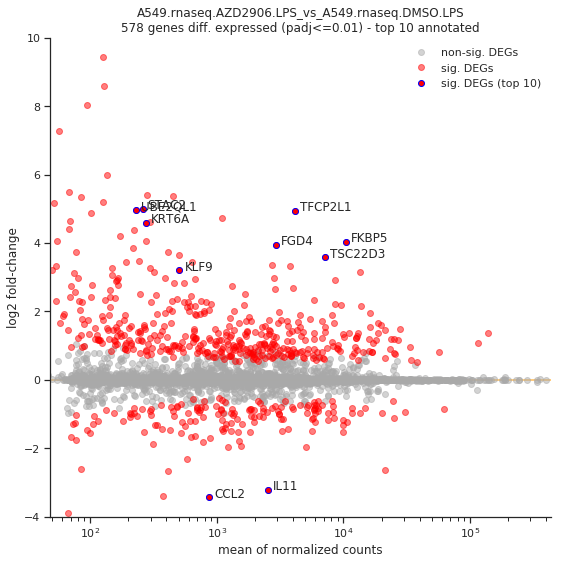

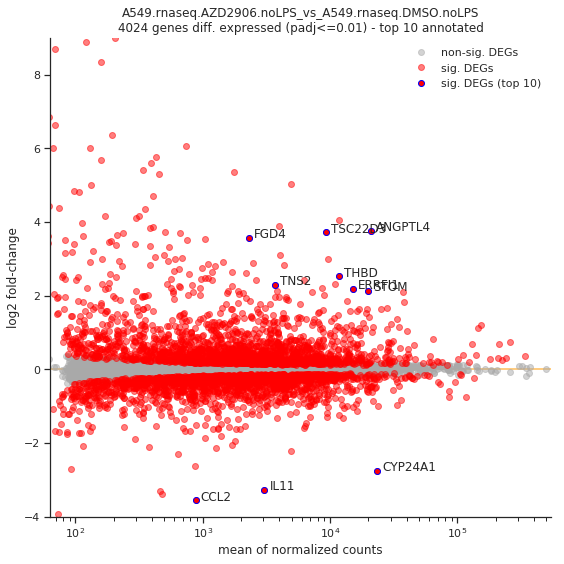

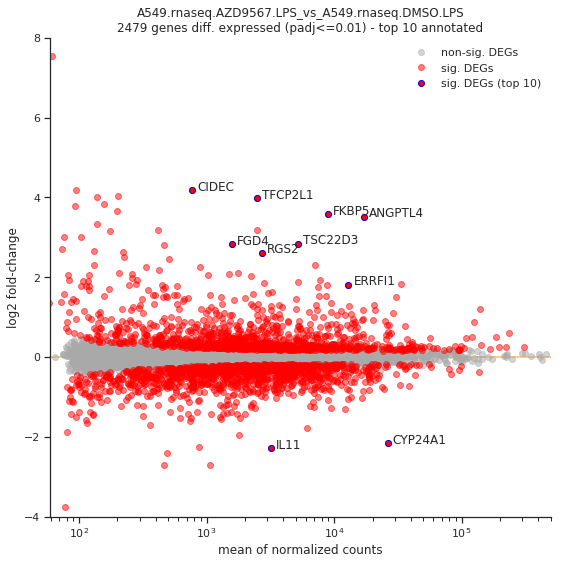

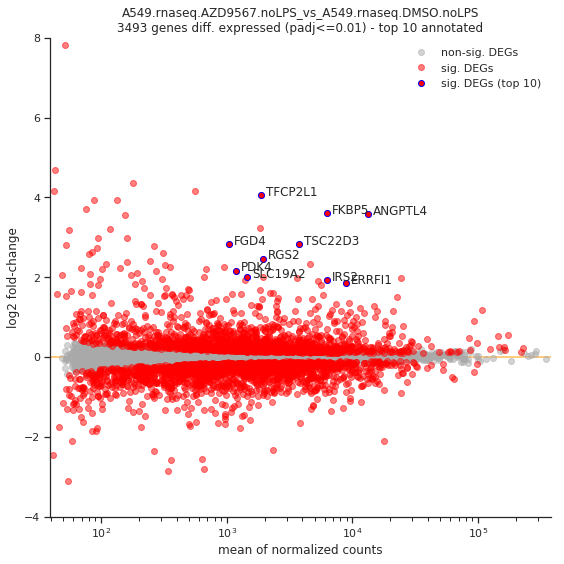

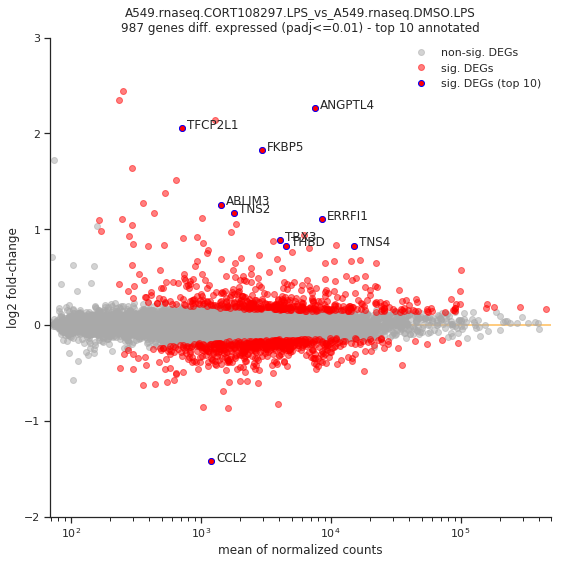

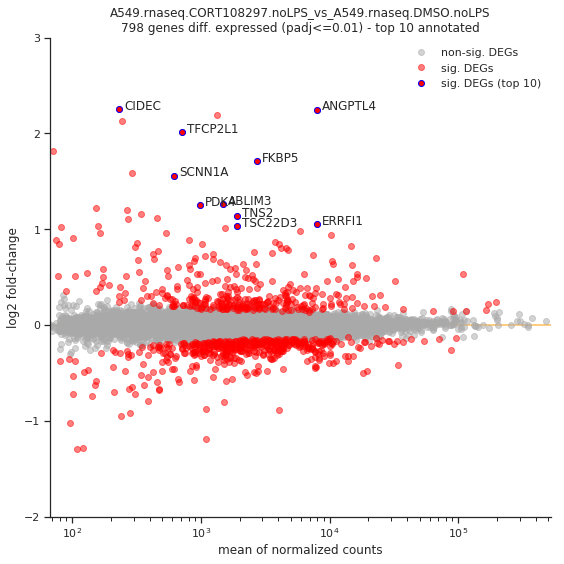

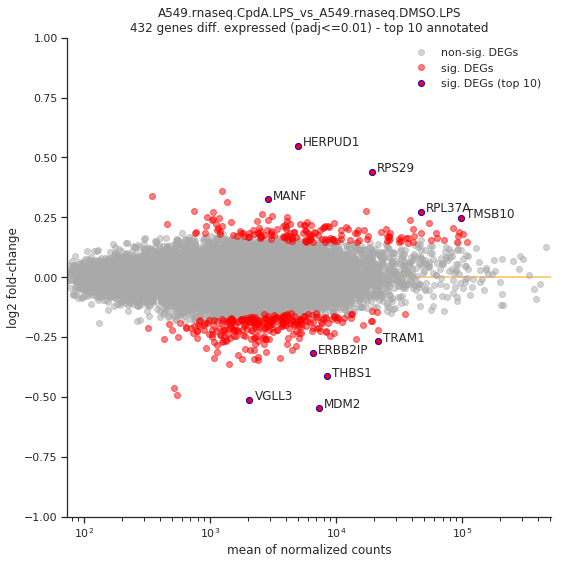

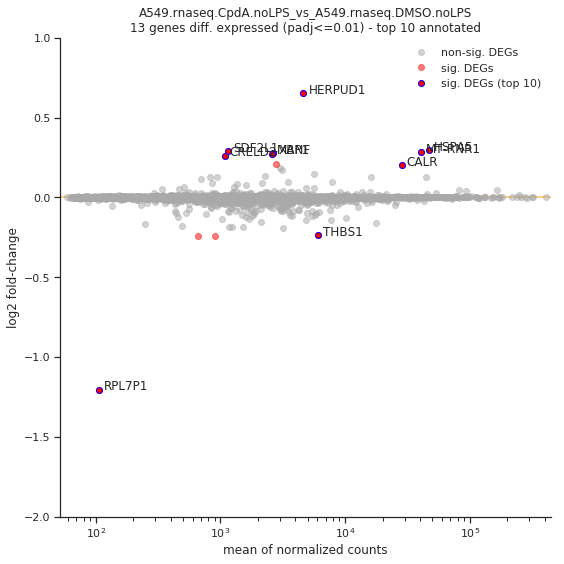

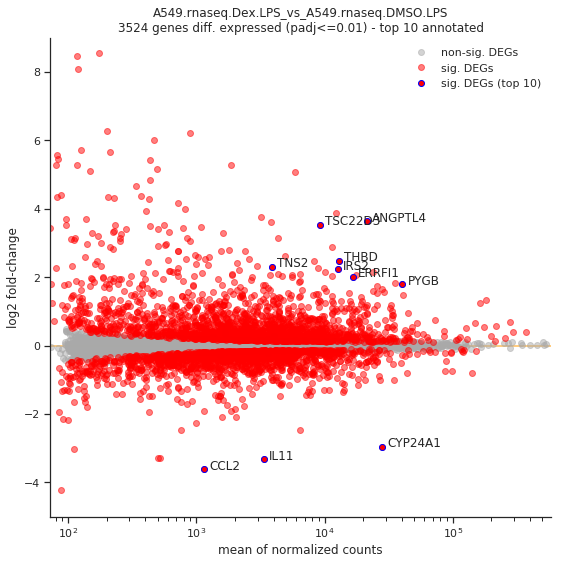

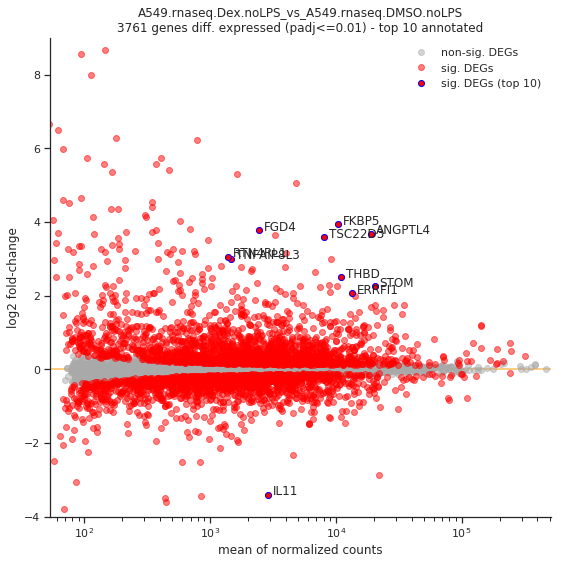

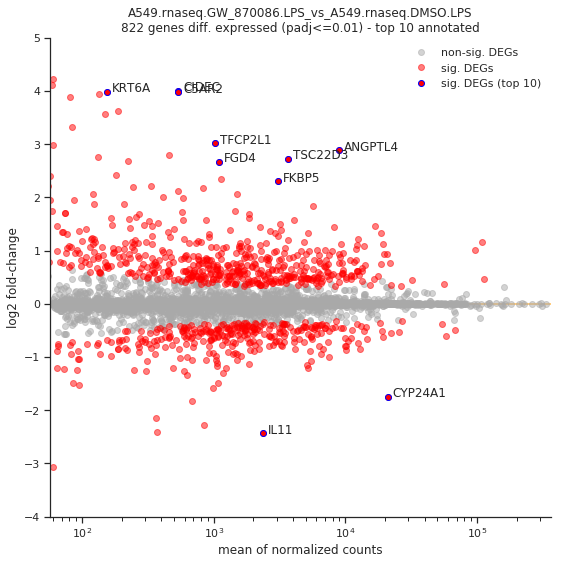

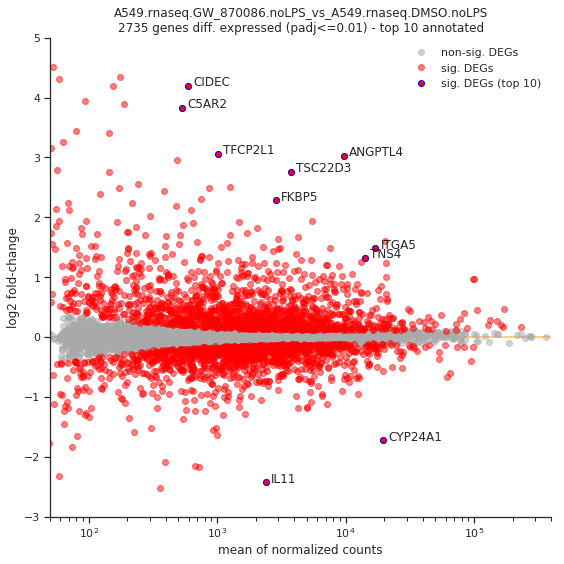

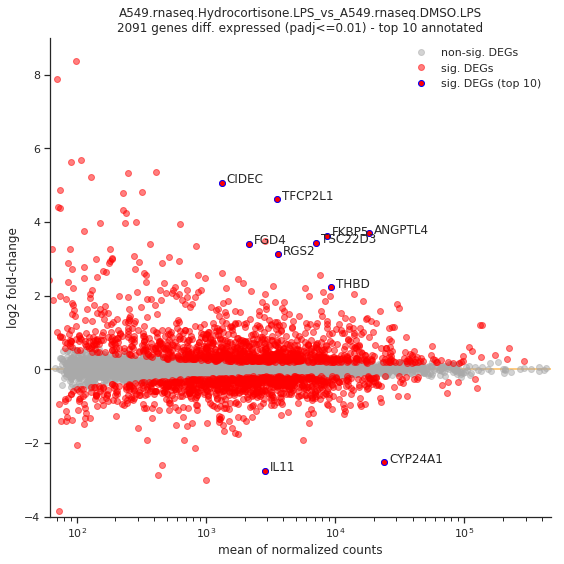

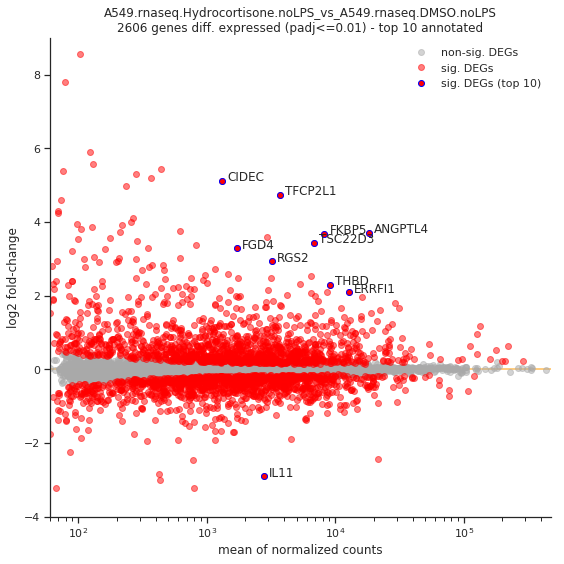

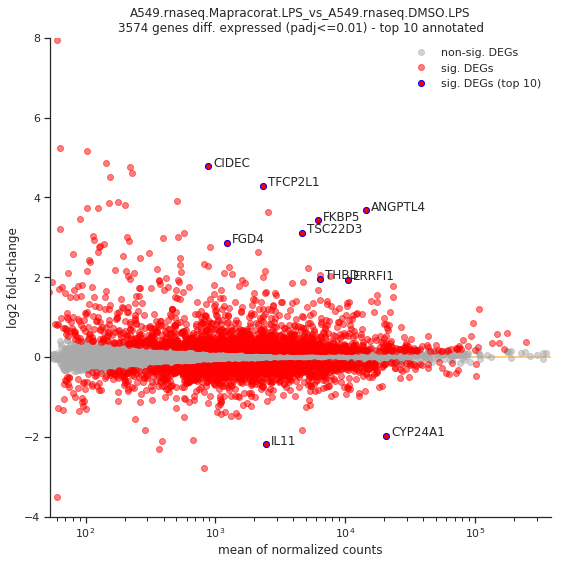

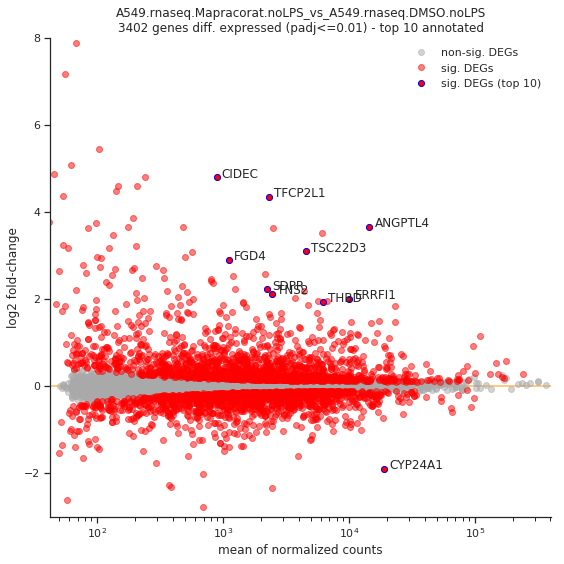

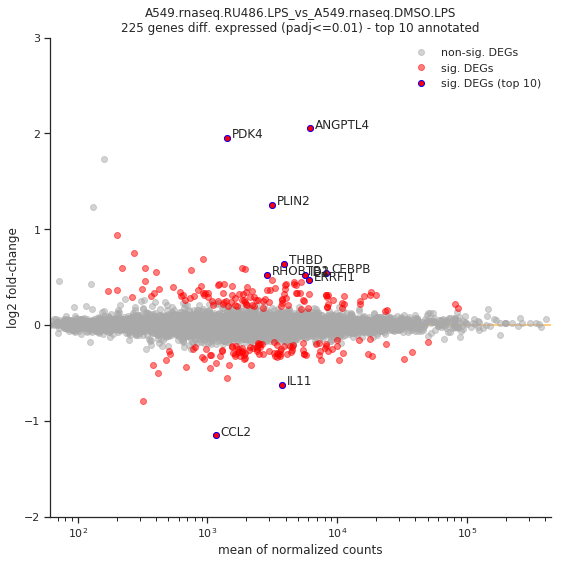

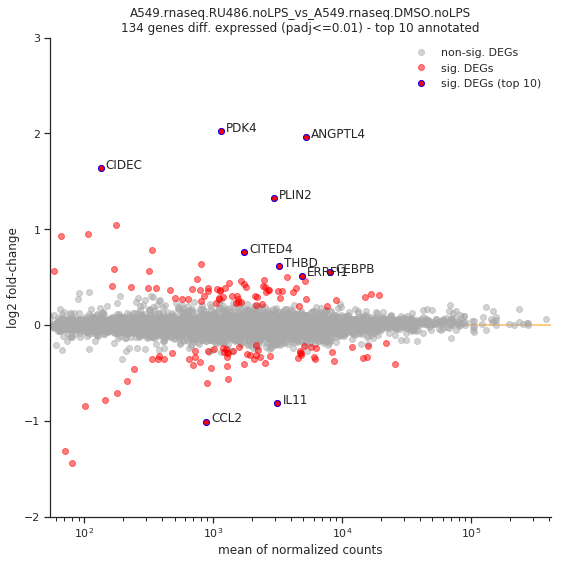

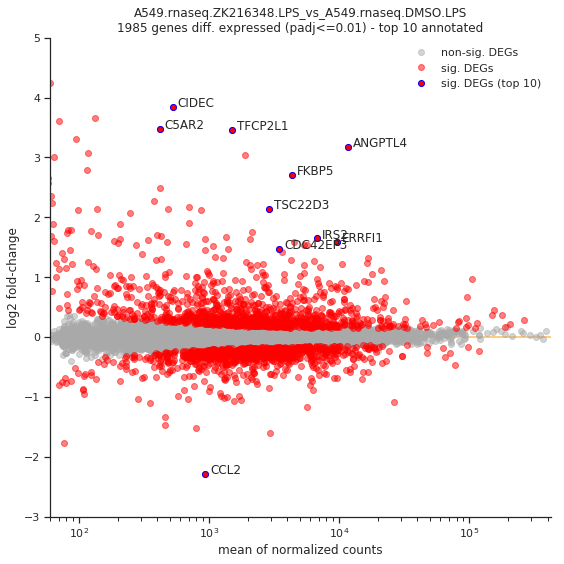

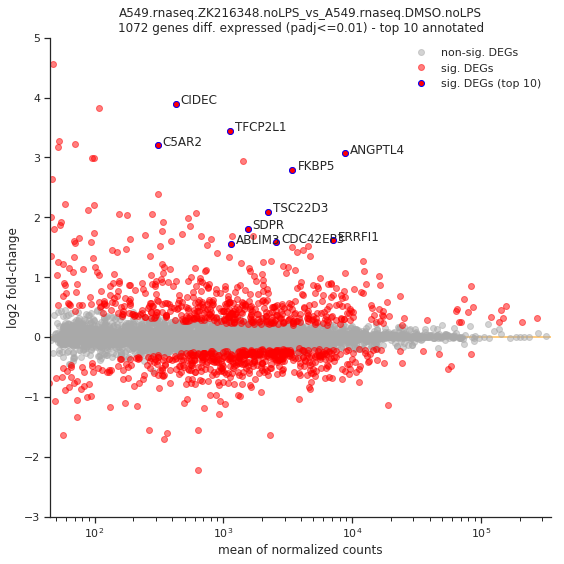

In [5]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 10
log2fc_thres = np.log2(2)
special_genes = []
comparisons = comps

data_dir = '/data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts'
for comparison in comparisons:
    for shrinkage in ['']:#, '.unshrunk'
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs', rasterized=True)

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, 
                label='sig. DEGs', rasterized=True)

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
        if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
            df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
        ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', 
                label='sig. DEGs (top %d)' % top_to_report, markeredgecolor='blue', rasterized=True)

        for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                        textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
#         df_annotate_selected = df[df.GeneName.isin(special_genes)]
#         ax.plot(df_annotate_selected['baseMean'].values, 
#                 df_annotate_selected['log2FoldChange'].values,color='blue', 
#                 marker='.', linestyle = 'None', alpha=1, label='interest genes')
#         for x, y, t in zip(df_annotate_selected['baseMean'].values,
#                            df_annotate_selected['log2FoldChange'].values, 
#                            df_annotate_selected['GeneName'].values) :
#             ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')
#         df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
#         ax.plot(df_annotate_selected['baseMean'].values, 
#                 df_annotate_selected['log2FoldChange'].values,color='blue', 
#                 marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
        plt.savefig("%s/%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))
    
        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   


In [2]:
comps=[
    "A549.rnaseq.DMSO.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.AZD2906.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.AZD9567.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.CORT108297.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.CpdA.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.Dex.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.GW_870086.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.Hydrocortisone.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.Mapracorat.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.RU486.LPS_vs_A549.rnaseq.DMSO.noLPS",
    "A549.rnaseq.ZK216348.LPS_vs_A549.rnaseq.DMSO.noLPS",
]



====== A549.rnaseq.DMSO.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0       baseMean  log2FoldChange     lfcSE      stat  \
0  ENSG00000198888.2   87142.000285        0.464493  0.091033  5.102459   
1  ENSG00000198899.2  112083.490456        0.379159  0.076909  4.929993   
2  ENSG00000228253.1   23709.557487        0.387649  0.080119  4.838406   
3  ENSG00000210077.1     360.194249        0.838659  0.180059  4.657698   
4  ENSG00000198886.2  201691.344461        0.373647  0.079808  4.681848   

         pvalue      padj GeneName  
0  3.352682e-07  0.004213   MT-ND1  
1  8.223271e-07  0.005166  MT-ATP6  
2  1.308845e-06  0.005482  MT-ATP8  
3  3.197644e-06  0.008036    MT-TV  
4  2.842999e-06  0.008036   MT-ND4

====== A549.rnaseq.AZD2906.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE       stat  \
0   ENSG00000115112.7  3375.076299        4.978292  0.193338  25.749168   
1  ENSG00000096060.13  8575.251355        4.088073  0.186819  21.882575   
2  ENSG00000157514.15  5897.106448        3.607496  0.175360  20.571964   
3   ENSG00000187288.9   895.088335        4.713960  0.275268  17.124973   
4   ENSG00000116741.7  3132.834071        3.249732  0.192526  16.879463   
5   ENSG00000108691.8   758.509521       -3.341607  0.201920 -16.549158   
6   ENSG00000158445.7   340.604134        3.672730  0.231083  15.893580   
7   ENSG00000095752.5  2577.077411       -3.346354  0.210871 -15.869233   
8   ENSG00000118523.5  7022.089864        3.036742  0.194786  15.590127   
9  ENSG00000168824.13   224.381834        4.278671  0.275128  15.551590   

          pvalue           padj GeneName  
0  3.293322e-146  4.208537e-142  TFCP2L1  
1  3.807247e-106  2.432640e-102    FKBP5  
2   4.894377e-94   2.084842e-90  TSC22D3  
3   9.665483e-66   3.087880e-62    CIDEC  
4   6.372234e-64   1.628616e-60     RGS2  
5   1.623587e-61   3.457969e-58     CCL2  
6   7.020124e-57   1.281574e-53    KCNB1  
7   1.034979e-56   1.653249e-53     IL11  
8   8.496450e-55   1.206401e-51     CTGF  
9   1.552046e-54   1.983360e-51  D4S234E

====== A549.rnaseq.AZD9567.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE       stat  \
0   ENSG00000115112.7   1998.597748        3.980979  0.085576  46.519935   
1  ENSG00000096060.13   7186.565196        3.598362  0.057544  62.532537   
2  ENSG00000167772.10  13998.949983        3.398406  0.069458  48.927630   
3   ENSG00000095752.5   3147.960795       -2.409736  0.060780 -39.646682   
4   ENSG00000019186.8  23975.011216       -2.218207  0.052788 -42.020788   
5  ENSG00000157514.15   4231.783168        2.850187  0.069649  40.922135   
6  ENSG00000116285.11  10678.216801        1.857107  0.054360  34.163416   
7   ENSG00000163171.7   4227.544076        1.995681  0.058750  33.969023   
8   ENSG00000116741.7   2272.800400        2.505123  0.074523  33.615349   
9   ENSG00000185950.8   7261.096910        1.876233  0.059076  31.759605   

          pvalue           padj  GeneName  
0   0.000000e+00   0.000000e+00   TFCP2L1  
1   0.000000e+00   0.000000e+00     FKBP5  
2   0.000000e+00   0.000000e+00   ANGPTL4  
3   0.000000e+00   0.000000e+00      IL11  
4   0.000000e+00   0.000000e+00   CYP24A1  
5   0.000000e+00   0.000000e+00   TSC22D3  
6  8.452642e-256  1.521959e-252    ERRFI1  
7  6.389494e-253  1.006665e-249  CDC42EP3  
8  1.001022e-247  1.401875e-244      RGS2  
9  2.339815e-221  2.949103e-218      IRS2

====== A549.rnaseq.CORT108297.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE       stat  \
0  ENSG00000167772.10  6369.331217        2.145372  0.060873  35.243394   
1  ENSG00000096060.13  2459.596495        1.845731  0.061691  29.918878   
2   ENSG00000115112.7   601.227653        2.061512  0.099351  20.749753   
3  ENSG00000116285.11  7234.137690        1.156460  0.058539  19.755370   
4  ENSG00000204634.11  5214.177911        1.028260  0.059465  17.291938   
5  ENSG00000106799.11  9038.588151        0.921037  0.053266  17.291327   
6  ENSG00000173210.18  1238.419165        1.247165  0.073481  16.972525   
7  ENSG00000111319.11   539.088418        1.637613  0.106042  15.443079   
8  ENSG00000135111.13  3524.861191        0.899244  0.059134  15.207001   
9  ENSG00000157514.15  1624.791684        1.091826  0.071983  15.167741   

          pvalue           padj GeneName  
0  4.331201e-272  5.443453e-268  ANGPTL4  
1  1.118135e-196  7.026361e-193    FKBP5  
2   1.232233e-95   5.162234e-92  TFCP2L1  
3   7.212466e-87   2.266157e-83   ERRFI1  
4   5.410223e-67   1.145343e-63   TBC1D8  
5   5.467902e-67   1.145343e-63   TGFBR1  
6   1.311697e-64   2.355058e-61   ABLIM3  
7   8.399280e-54   1.319527e-50   SCNN1A  
8   3.177710e-52   4.437496e-49     TBX3  
9   5.783346e-52   7.268510e-49  TSC22D3

====== A549.rnaseq.CpdA.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE      stat  \
0  ENSG00000051108.13   4520.215366        0.515367  0.062539  8.240719   
1   ENSG00000214485.6    122.794058       -1.081096  0.196583 -5.499440   
2  ENSG00000164916.10   3616.236004       -0.436607  0.078512 -5.560987   
3   ENSG00000044574.7  48823.501472        0.286932  0.053299  5.383415   
4  ENSG00000135679.20   6051.266615       -0.372837  0.073491 -5.073257   
5   ENSG00000213064.8   4810.307894       -0.411500  0.084403 -4.875419   
6  ENSG00000137801.10   6806.304259       -0.298748  0.061765 -4.836819   
7   ENSG00000227063.5    818.024564        0.548851  0.114382  4.798408   
8   ENSG00000128228.4   1157.257290        0.462644  0.099311  4.658544   

         pvalue          padj GeneName  
0  1.711787e-16  2.148293e-12  HERPUD1  
1  3.809996e-08  1.593848e-04   RPL7P1  
2  2.682539e-08  1.593848e-04    FOXK1  
3  7.308573e-08  2.293065e-04    HSPA5  
4  3.910647e-07  9.815724e-04     MDM2  
5  1.085775e-06  2.271079e-03   SFT2D2  
6  1.319335e-06  2.365379e-03    THBS1  
7  1.599316e-06  2.508927e-03  RPL41P1  
8  3.184534e-06  4.440656e-03   SDF2L1

====== A549.rnaseq.Dex.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE       stat  \
0    ENSG00000116741.7   3508.312440        3.022643  0.072006  41.977881   
10  ENSG00000157514.15   7302.355912        3.538383  0.064246  55.075151   
8    ENSG00000095752.5   3311.908719       -3.429987  0.073174 -46.874379   
7   ENSG00000167772.10  16980.539468        3.511441  0.067337  52.147235   
6   ENSG00000139132.13   2511.874059        3.831279  0.090394  42.384398   
9    ENSG00000019186.8  25286.862905       -3.007617  0.061854 -48.624177   
4   ENSG00000096060.13   9736.931531        3.889374  0.058991  65.931467   
3    ENSG00000187288.9   1459.926996        5.176145  0.115549  44.796054   
2    ENSG00000168497.4   3921.289833        2.748363  0.072022  38.160061   
1    ENSG00000115112.7   4628.605753        5.076432  0.082507  61.527013   

    pvalue  padj GeneName  
0      0.0   0.0     RGS2  
10     0.0   0.0  TSC22D3  
8      0.0   0.0     IL11  
7      0.0   0.0  ANGPTL4  
6      0.0   0.0     FGD4  
9      0.0   0.0  CYP24A1  
4      0.0   0.0    FKBP5  
3      0.0   0.0    CIDEC  
2      0.0   0.0     SDPR  
1      0.0   0.0  TFCP2L1

====== A549.rnaseq.GW_870086.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE       stat  \
0  ENSG00000157514.15   3109.643286        2.757212  0.102255  26.964004   
1  ENSG00000167772.10   7550.020874        2.787799  0.107437  25.948209   
2   ENSG00000115112.7    861.113787        3.037341  0.122429  24.809052   
3   ENSG00000187288.9    448.662167        3.943208  0.159522  24.718950   
4   ENSG00000134830.5    450.354163        3.751803  0.161394  23.246235   
5   ENSG00000095752.5   2411.226819       -2.549915  0.113210 -22.523739   
6  ENSG00000096060.13   2617.318546        2.339215  0.105656  22.139843   
7   ENSG00000019186.8  19545.402568       -1.807775  0.092139 -19.620127   
8   ENSG00000278309.1    383.934639        2.916059  0.153515  18.995227   
9  ENSG00000139132.13    913.042386        2.768553  0.150734  18.367082   

          pvalue           padj       GeneName  
0  3.908670e-160  4.936650e-156        TSC22D3  
1  1.904911e-148  1.202951e-144        ANGPTL4  
2  7.159461e-136  3.014133e-132        TFCP2L1  
3  6.690914e-135  2.112656e-131          CIDEC  
4  1.552891e-119  3.922603e-116          C5AR2  
5  2.429747e-112  5.114618e-109           IL11  
6  1.306923e-108  2.358063e-105          FKBP5  
7   1.040921e-85   1.643354e-82        CYP24A1  
8   1.867791e-80   2.621134e-77  RP11-102K13.5  
9   2.410252e-75   3.044149e-72           FGD4

====== A549.rnaseq.Hydrocortisone.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE       stat  \
0   ENSG00000115112.7   2879.064903        4.622868  0.097706  47.314158   
1  ENSG00000096060.13   7055.484416        3.649193  0.076016  48.005312   
2  ENSG00000157514.15   5799.754772        3.445453  0.089345  38.563360   
3  ENSG00000167772.10  15071.240855        3.582447  0.096702  37.046396   
4   ENSG00000187288.9   1065.987837        4.986237  0.136188  36.612796   
5   ENSG00000019186.8  22091.733550       -2.584536  0.076694 -33.699306   
6  ENSG00000139132.13   1735.246906        3.486052  0.104337  33.411366   
7   ENSG00000116741.7   2975.811952        3.005100  0.094213  31.896787   
8   ENSG00000095752.5   2895.116262       -2.874238  0.090566 -31.736277   
9   ENSG00000163171.7   4758.132727        2.301761  0.077192  29.818748   

          pvalue           padj  GeneName  
0   0.000000e+00   0.000000e+00   TFCP2L1  
1   0.000000e+00   0.000000e+00     FKBP5  
2   0.000000e+00   0.000000e+00   TSC22D3  
3  2.052577e-300  6.501536e-297   ANGPTL4  
4  1.789795e-293  4.535340e-290     CIDEC  
5  5.917493e-249  1.249577e-245   CYP24A1  
6  9.375199e-245  1.696911e-241      FGD4  
7  2.958520e-223  4.685556e-220      RGS2  
8  4.910739e-221  6.913229e-218      IL11  
9  2.232650e-195  2.828768e-192  CDC42EP3

====== A549.rnaseq.Mapracorat.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE       stat  \
0   ENSG00000115112.7   1917.758639        4.289615  0.086772  49.435411   
1   ENSG00000187288.9    730.969656        4.694275  0.124059  37.839028   
2  ENSG00000096060.13   5118.032834        3.446109  0.060267  57.180681   
3  ENSG00000167772.10  12190.590803        3.559530  0.066474  53.547929   
4  ENSG00000157514.15   3920.364841        3.120281  0.066717  46.768937   
5   ENSG00000128016.5   5388.413796        2.117311  0.058789  36.015184   
6   ENSG00000019186.8  19329.741385       -2.018871  0.057347 -35.204187   
7   ENSG00000095752.5   2505.125204       -2.302669  0.069305 -33.225338   
8   ENSG00000116741.7   1830.197214        2.507018  0.076530  32.758723   
9  ENSG00000116285.11   8966.153571        1.979153  0.060710  32.600047   

          pvalue           padj GeneName  
0   0.000000e+00   0.000000e+00  TFCP2L1  
1   0.000000e+00   0.000000e+00    CIDEC  
2   0.000000e+00   0.000000e+00    FKBP5  
3   0.000000e+00   0.000000e+00  ANGPTL4  
4   0.000000e+00   0.000000e+00  TSC22D3  
5  4.840052e-284  1.021493e-280    ZFP36  
6  1.725289e-271  3.121048e-268  CYP24A1  
7  4.636857e-242  7.339566e-239     IL11  
8  2.281026e-235  3.209404e-232     RGS2  
9  4.094884e-233  5.185351e-230   ERRFI1

====== A549.rnaseq.RU486.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE       stat  \
0  ENSG00000167772.10  5294.184156        1.936905  0.077940  24.851292   
1   ENSG00000004799.7  1162.395092        2.036578  0.086113  23.649986   
2   ENSG00000147872.8  2789.132588        1.214839  0.074859  16.228317   
3   ENSG00000236824.1   718.394853        1.285191  0.107726  11.930232   
4   ENSG00000095752.5  3584.846857       -0.758962  0.071061 -10.680423   
5   ENSG00000108691.8   990.181354       -1.050587  0.121608  -8.639093   
6   ENSG00000187288.9   135.643782        1.703539  0.202500   8.412536   
7  ENSG00000116285.11  5215.877209        0.545359  0.067037   8.135236   
8  ENSG00000204634.11  4008.303880        0.566347  0.070455   8.038400   
9   ENSG00000178726.6  3415.052294        0.625652  0.079286   7.891082   

          pvalue           padj GeneName  
0  2.504037e-136  3.153334e-132  ANGPTL4  
1  1.180716e-123  7.434377e-120     PDK4  
2   3.180625e-59   1.335120e-55    PLIN2  
3   8.234323e-33   2.592371e-29   BCYRN1  
4   1.256977e-26   3.165823e-23     IL11  
5   5.666117e-18   1.189224e-14     CCL2  
6   4.012397e-17   7.218303e-14    CIDEC  
7   4.111383e-16   6.471831e-13   ERRFI1  
8   9.101935e-16   1.273563e-12   TBC1D8  
9   2.995771e-15   3.772574e-12     THBD

====== A549.rnaseq.ZK216348.LPS_vs_A549.rnaseq.DMSO.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE       stat  \
0  ENSG00000096060.13  3587.119251        2.737314  0.072827  37.586559   
1  ENSG00000167772.10  9689.012086        3.063361  0.089552  34.207481   
2   ENSG00000115112.7  1233.693707        3.483708  0.115884  30.062083   
3  ENSG00000179094.12  1582.888367        3.083613  0.110699  27.855900   
4  ENSG00000157514.15  2444.079905        2.161455  0.079126  27.316695   
5   ENSG00000187288.9   433.510482        3.785113  0.157220  24.075262   
6  ENSG00000116285.11  8152.279008        1.648663  0.070988  23.224595   
7   ENSG00000163171.7  2897.318402        1.587222  0.074935  21.181244   
8   ENSG00000134830.5   349.943761        3.234764  0.154082  20.993768   
9   ENSG00000118523.5  3037.861820        1.541492  0.074784  20.612582   

          pvalue           padj  GeneName  
0   0.000000e+00   0.000000e+00     FKBP5  
1  1.871643e-256  1.182598e-252   ANGPTL4  
2  1.517836e-198  6.393631e-195   TFCP2L1  
3  9.137143e-171  2.886652e-167      PER1  
4  2.687006e-164  6.791139e-161   TSC22D3  
5  4.540707e-128  9.563485e-125     CIDEC  
6  2.569882e-119  4.639371e-116    ERRFI1  
7   1.422262e-99   2.246641e-96  CDC42EP3  
8   7.477683e-98   1.049950e-94     C5AR2  
9   2.116344e-94   2.674424e-91      CTGF

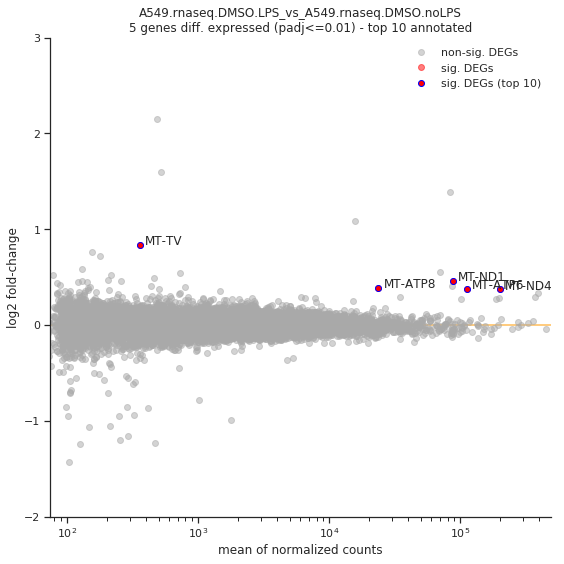

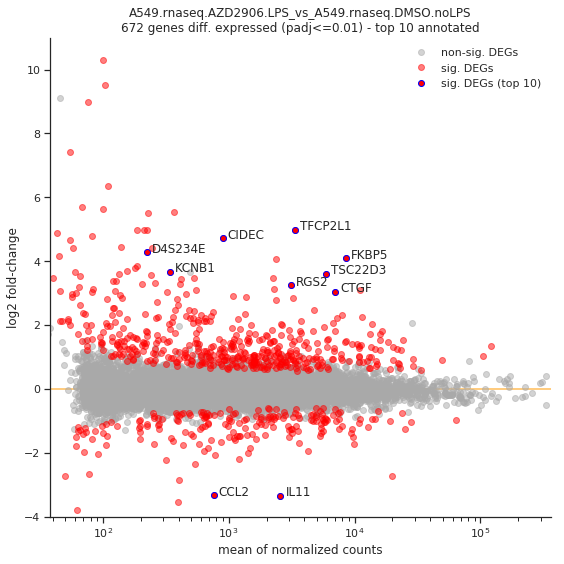

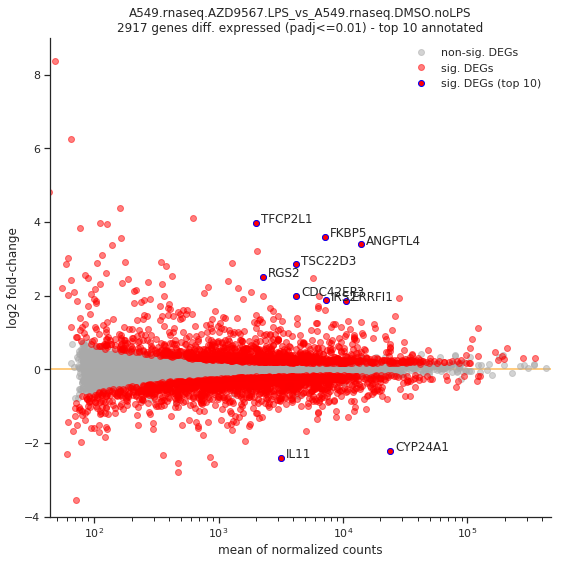

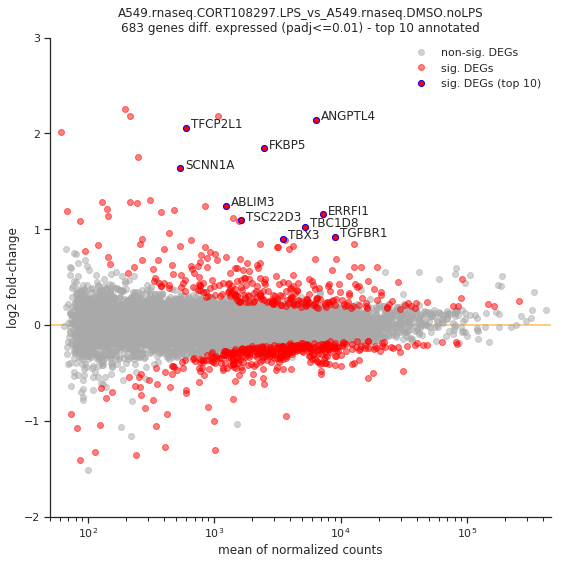

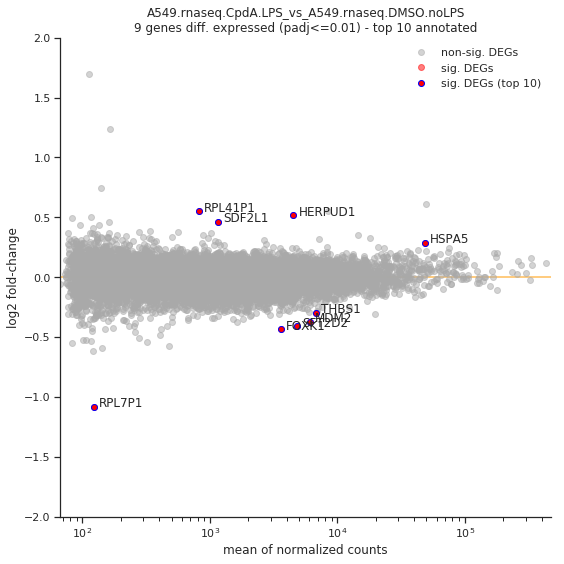

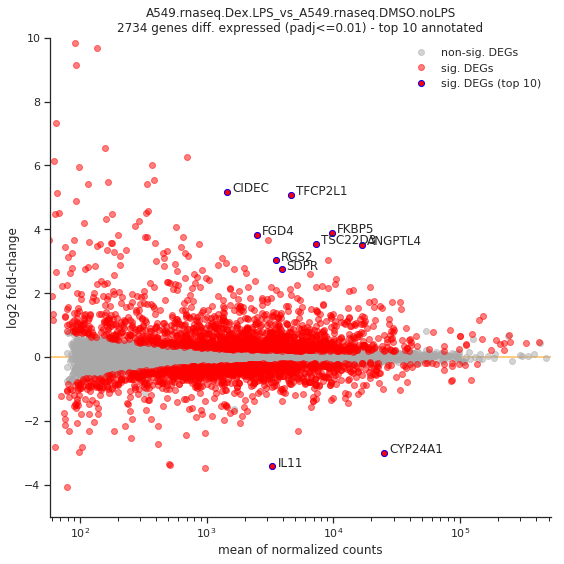

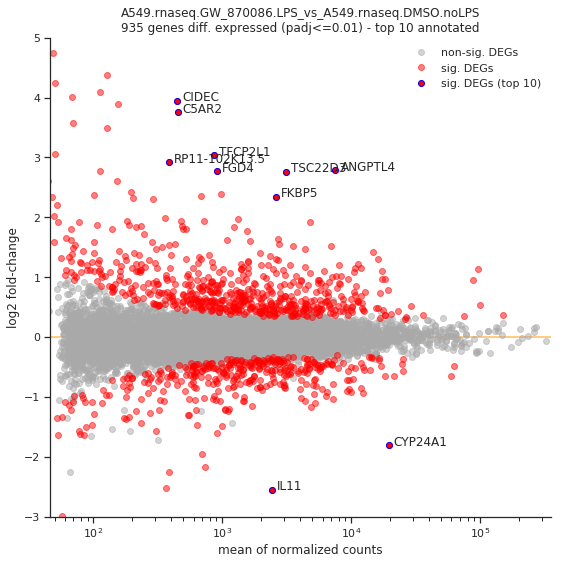

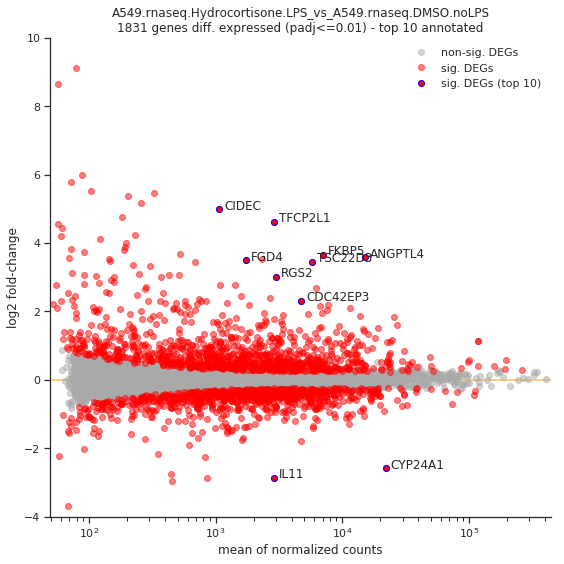

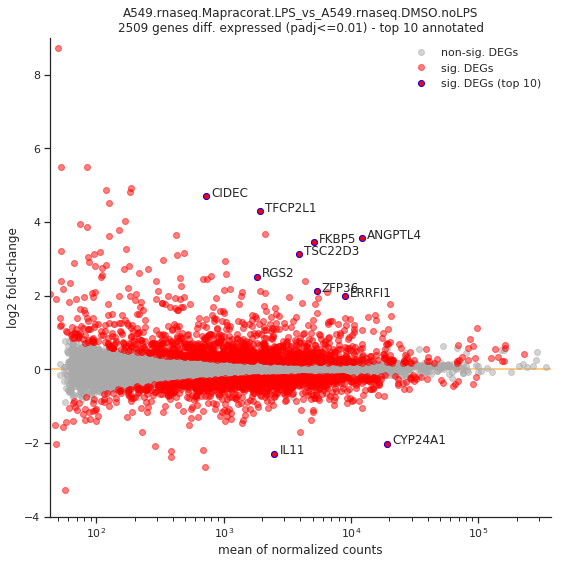

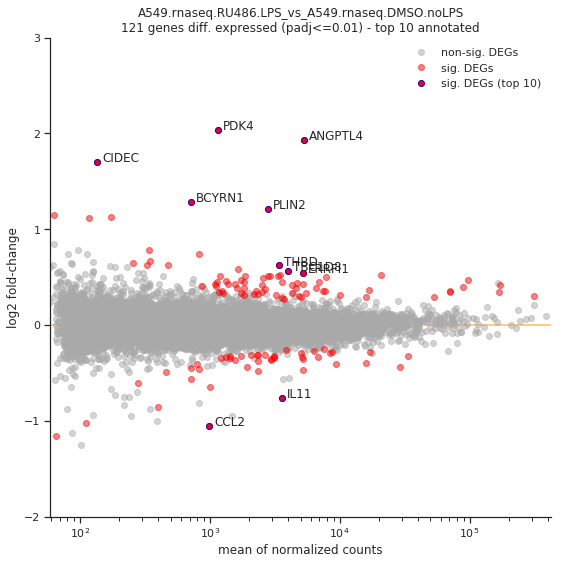

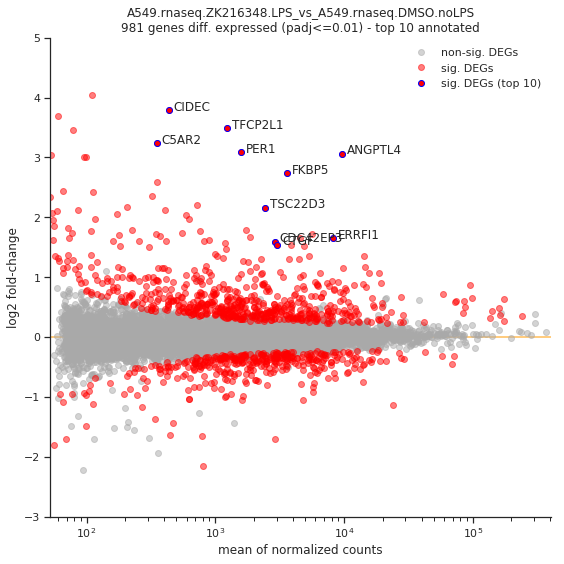

In [3]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 10
log2fc_thres = np.log2(2)
special_genes = []
comparisons = comps

data_dir = '/data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts'
for comparison in comparisons:
    for shrinkage in ['.unshrunk']:#, 
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs', rasterized=True)

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, 
                label='sig. DEGs', rasterized=True)

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
        if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
            df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
        ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', 
                label='sig. DEGs (top %d)' % top_to_report, markeredgecolor='blue', rasterized=True)

        for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                        textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
#         df_annotate_selected = df[df.GeneName.isin(special_genes)]
#         ax.plot(df_annotate_selected['baseMean'].values, 
#                 df_annotate_selected['log2FoldChange'].values,color='blue', 
#                 marker='.', linestyle = 'None', alpha=1, label='interest genes')
#         for x, y, t in zip(df_annotate_selected['baseMean'].values,
#                            df_annotate_selected['log2FoldChange'].values, 
#                            df_annotate_selected['GeneName'].values) :
#             ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')
#         df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
#         ax.plot(df_annotate_selected['baseMean'].values, 
#                 df_annotate_selected['log2FoldChange'].values,color='blue', 
#                 marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
        plt.savefig("%s/%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))
    
        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   


Pairwise -noLPS

In [2]:
comps=[
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.AZD9567.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.CORT108297.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.CpdA.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.Dex.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.GW_870086.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.Mapracorat.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.CORT108297.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.CpdA.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.Dex.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.GW_870086.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.Mapracorat.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.CpdA.noLPS",
    "A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.Dex.noLPS",
    "A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.GW_870086.noLPS",
    "A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS",
    "A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.Mapracorat.noLPS",
    "A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.Dex.noLPS",
    "A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.GW_870086.noLPS",
    "A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS",
    "A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.Mapracorat.noLPS",
    "A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.GW_870086.noLPS",
    "A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS",
    "A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.Mapracorat.noLPS",
    "A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS",
    "A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.Mapracorat.noLPS",
    "A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.Hydrocortisone.noLPS_vs_A549.rnaseq.Mapracorat.noLPS",
    "A549.rnaseq.Hydrocortisone.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.Hydrocortisone.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.Mapracorat.noLPS_vs_A549.rnaseq.RU486.noLPS",
    "A549.rnaseq.Mapracorat.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
    "A549.rnaseq.RU486.noLPS_vs_A549.rnaseq.ZK216348.noLPS",
]



In [3]:
%matplotlib inline

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.AZD9567.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   6055.754606        0.968450  0.029328  4.840506e-240   
1  ENSG00000143845.13   1036.871746        1.697344  0.056309  6.249838e-207   
2  ENSG00000101265.14   3861.794185        0.972626  0.033736  1.056730e-183   
3   ENSG00000163283.6    753.112339        2.167561  0.082972  2.319685e-155   
4   ENSG00000187288.9   2026.460306        1.200886  0.045521  9.069046e-155   
5  ENSG00000157514.15  11011.536178        0.872649  0.034525  8.069957e-142   
6   ENSG00000141750.6    378.363144        2.410102  0.102296  4.981605e-124   
7  ENSG00000136802.10  14552.849670        0.652781  0.028445  6.296581e-118   
8  ENSG00000055118.13    372.744929        1.973252  0.090372  6.114470e-115   
9  ENSG00000166592.10   2241.495685        1.137263  0.051275  3.223047e-110   

            padj GeneName  
0  6.107750e-236  TFCP2L1  
1  3.943023e-203    ETNK2  
2  4.444606e-180   RASSF2  
3  7.317447e-152     ALPP  
4  2.288664e-151    CIDEC  
5  1.697112e-138  TSC22D3  
6  8.979698e-121    STAC2  
7  9.931283e-115   LRRC8A  
8  8.572488e-112    KCNH2  
9  4.066841e-107     RRAD

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.CORT108297.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0    ENSG00000127129.8   1287.194123        2.268204  0.060237     0.0   0.0   
21   ENSG00000148677.6   1998.876950        2.086093  0.055306     0.0   0.0   
22  ENSG00000137486.15   1176.382318        2.330428  0.062075     0.0   0.0   
23  ENSG00000139132.13   2687.403185        2.765447  0.059626     0.0   0.0   
24  ENSG00000111696.10   5040.063240        1.869276  0.042289     0.0   0.0   
25   ENSG00000185950.8  13628.578446        1.511918  0.038839     0.0   0.0   
26   ENSG00000183578.5   1720.172633        2.174688  0.050643     0.0   0.0   
28   ENSG00000102996.4   6823.606313        1.445689  0.032236     0.0   0.0   
20  ENSG00000136802.10  15673.518235        1.636783  0.029957     0.0   0.0   
29   ENSG00000185924.6   1440.716251        2.319920  0.053175     0.0   0.0   

     GeneName  
0        EDN2  
21     ANKRD1  
22      ARRB1  
23       FGD4  
24     NT5DC3  
25       IRS2  
26  TNFAIP8L3  
28      MMP15  
20     LRRC8A  
29    RTN4RL1

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.CpdA.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11  14281.354264        2.143604  0.033563     0.0   0.0   
34  ENSG00000166689.13   4364.543501        1.925700  0.049453     0.0   0.0   
36  ENSG00000139132.13   2135.507195        3.939673  0.070101     0.0   0.0   
37   ENSG00000139211.6  10884.980334       -1.220656  0.031421     0.0   0.0   
38   ENSG00000161638.9  23987.588880        1.633521  0.028845     0.0   0.0   
39  ENSG00000111696.10   4151.188062        2.151173  0.040678     0.0   0.0   
40  ENSG00000151136.13   7007.098305        1.431059  0.033625     0.0   0.0   
41  ENSG00000135111.13   5129.806424        1.486552  0.035796     0.0   0.0   
42   ENSG00000185950.8  10258.273795        2.393421  0.045966     0.0   0.0   
43   ENSG00000183578.5   1351.986913        3.018624  0.065530     0.0   0.0   

     GeneName  
0      ERRFI1  
34    PLEKHA7  
36       FGD4  
37     AMIGO2  
38      ITGA5  
39     NT5DC3  
40     BTBD11  
41       TBX3  
42       IRS2  
43  TNFAIP8L3

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.Dex.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE        pvalue  \
0   ENSG00000215218.3   549.325989        0.977953  0.094595  2.604960e-26   
1  ENSG00000168874.11  1695.193049        0.565725  0.091894  3.727235e-14   
2  ENSG00000059804.14  1313.071206        0.394990  0.064179  1.015927e-13   
3  ENSG00000122861.14  9301.435413        0.384039  0.063785  3.041005e-13   
4   ENSG00000279117.1  1359.756664       -0.408914  0.070295  4.948946e-13   
5   ENSG00000198042.9  3726.134282       -0.366704  0.071797  5.842275e-11   
6  ENSG00000101265.14  7889.259637       -0.328647  0.064610  1.214619e-10   
7   ENSG00000146678.8  4546.467523        0.345780  0.071731  3.317376e-10   
8   ENSG00000134917.9   326.208214        0.531153  0.123884  6.109415e-10   
9  ENSG00000163597.13  6205.202055       -0.298166  0.064906  1.794231e-09   

           padj       GeneName  
0  2.825340e-22        UBE2QL1  
1  2.021280e-10          ATOH8  
2  3.672914e-10         SLC2A3  
3  8.245685e-10           PLAU  
4  1.073525e-09  CTD-2562J17.6  
5  1.056089e-07          MAK16  
6  1.881966e-07         RASSF2  
7  4.497532e-07         IGFBP1  
8  7.362524e-07        ADAMTS8  
9  1.946023e-06         SNHG16

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.GW_870086.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   5170.362647        1.950211  0.042345   0.000000e+00   
1  ENSG00000096060.13  12309.321949        1.764446  0.032851   0.000000e+00   
2   ENSG00000004799.7   2396.714462        1.847494  0.048164   0.000000e+00   
3   ENSG00000168209.4  15201.770356        1.360087  0.035522   0.000000e+00   
4   ENSG00000118523.5   9865.874920        1.522489  0.042314  7.983009e-287   
5  ENSG00000069869.14  16375.781289        1.024943  0.029162  1.115413e-271   
6   ENSG00000178726.6  11676.899610        1.408700  0.040476  6.594758e-268   
7   ENSG00000185950.8  11202.873056        1.174698  0.034403  6.966212e-257   
8  ENSG00000111696.10   4229.775338        1.369772  0.040502  5.610435e-253   
9  ENSG00000148175.11  21149.388399        0.934230  0.028281  2.352014e-240   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00     PDK4  
3   0.000000e+00    DDIT4  
4  2.012995e-283     CTGF  
5  2.343854e-268    NEDD4  
6  1.187810e-264     THBD  
7  1.097875e-253     IRS2  
8  7.859596e-250   NT5DC3  
9  2.965419e-237     STOM

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000059804.14   1028.627365        1.122288  0.061435  3.530529e-78   
1   ENSG00000215218.3    459.633900        1.575844  0.087391  6.569609e-77   
2   ENSG00000118523.5  15338.609395        0.465458  0.030127  8.006055e-56   
3  ENSG00000107372.11  20795.535838        0.438706  0.031231  7.591645e-47   
4  ENSG00000096060.13  20485.841965        0.370158  0.028890  1.010841e-39   
5  ENSG00000143845.13   1655.688271        0.572972  0.048636  8.717267e-34   
6   ENSG00000143878.9  39801.365403        0.333893  0.028771  2.649576e-33   
7  ENSG00000069869.14  23947.374901        0.333463  0.028895  5.627038e-33   
8  ENSG00000184205.13   2577.729513        0.522650  0.045651  3.079873e-32   
9  ENSG00000168874.11   1615.209203        0.543888  0.048533  5.504305e-31   

           padj GeneName  
0  4.444583e-74   SLC2A3  
1  4.135240e-73  UBE2QL1  
2  3.359607e-52     CTGF  
3  2.389280e-43   ZFAND5  
4  2.545097e-36    FKBP5  
5  1.829028e-30    ETNK2  
6  4.765073e-30     RHOB  
7  8.854847e-30    NEDD4  
8  4.308058e-29   TSPYL2  
9  6.929369e-28    ATOH8

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.Mapracorat.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000118523.5  11572.355786        0.811786  0.038183  8.038956e-102   
1  ENSG00000163659.11   8133.490480        0.815785  0.038871   2.638186e-99   
2  ENSG00000107372.11  15814.246447        0.749133  0.036854   2.251400e-93   
3  ENSG00000059804.14    803.730131        1.420112  0.070642   1.663689e-91   
4  ENSG00000148175.11  22930.558896        0.641743  0.032073   2.015988e-90   
5   ENSG00000163283.6    858.211798        1.421465  0.071231   3.162808e-90   
6  ENSG00000166592.10   2441.176541        0.913434  0.046270   3.876900e-88   
7  ENSG00000069869.14  18155.145934        0.636699  0.033738   8.599006e-81   
8  ENSG00000151726.12   4259.858818        0.723071  0.038505   3.616208e-80   
9   ENSG00000115112.7   6736.685233        0.667193  0.036046   6.767870e-78   

           padj GeneName  
0  1.013552e-97     CTGF  
1  1.663112e-95   TIPARP  
2  9.461885e-90   ZFAND5  
3  5.243948e-88   SLC2A3  
4  5.083515e-87     STOM  
5  6.646113e-87     ALPP  
6  6.982851e-85     RRAD  
7  1.355203e-77    NEDD4  
8  5.065906e-77    ACSL1  
9  8.532930e-75  TFCP2L1

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000116741.7   3521.129308        2.717371  0.068924   0.000000e+00   
7  ENSG00000179094.12   3461.907500        3.283622  0.065763   0.000000e+00   
6  ENSG00000139132.13   1962.427991        3.452611  0.076282   0.000000e+00   
5   ENSG00000118523.5   8311.952215        2.816594  0.066498   0.000000e+00   
8  ENSG00000157514.15   8060.445082        3.273811  0.056310   0.000000e+00   
3   ENSG00000187288.9   1563.227046        3.593926  0.095049   0.000000e+00   
2   ENSG00000168497.4   3755.366289        2.569803  0.064304   0.000000e+00   
1   ENSG00000115112.7   4262.581097        4.528906  0.069620   0.000000e+00   
4  ENSG00000096060.13  10191.183127        3.689636  0.064489   0.000000e+00   
9  ENSG00000148175.11  17475.572493        1.911185  0.054567  6.736137e-270   

            padj GeneName  
0   0.000000e+00     RGS2  
7   0.000000e+00     PER1  
6   0.000000e+00     FGD4  
5   0.000000e+00     CTGF  
8   0.000000e+00  TSC22D3  
3   0.000000e+00    CIDEC  
2   0.000000e+00     SDPR  
1   0.000000e+00  TFCP2L1  
4   0.000000e+00    FKBP5  
9  8.548831e-267     STOM

====== A549.rnaseq.AZD2906.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000157514.15   8480.121395        1.598536  0.057488  4.313797e-171   
1   ENSG00000118523.5   8292.173671        1.717598  0.069577  1.205154e-135   
2   ENSG00000163283.6    615.075659        2.833109  0.123875  2.284746e-124   
3  ENSG00000166592.10   1754.693371        1.868363  0.079728  7.889103e-123   
4  ENSG00000143845.13    886.872789        1.984206  0.085357  3.180800e-121   
5   ENSG00000115112.7   4774.149718        1.557832  0.068961  7.187728e-114   
6  ENSG00000151726.12   3191.185547        1.338910  0.061051  2.546955e-107   
7   ENSG00000187486.5    329.770246        2.860759  0.138934  8.872527e-103   
8  ENSG00000148175.11  17259.200573        1.210639  0.059572   1.361623e-92   
9  ENSG00000166589.11    368.049503        2.445948  0.124703   2.203965e-90   

            padj GeneName  
0  5.462992e-167  TSC22D3  
1  7.631036e-132     CTGF  
2  9.644674e-121     ALPP  
3  2.497690e-119     RRAD  
4  8.056331e-118    ETNK2  
5  1.517090e-110  TFCP2L1  
6  4.607806e-104    ACSL1  
7   1.404521e-99   KCNJ11  
8   1.915956e-89     STOM  
9   2.791102e-87    CDH16

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.CORT108297.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   2410.988155        2.029766  0.048719   0.000000e+00   
1  ENSG00000096060.13   8163.670373        1.893292  0.034456   0.000000e+00   
2   ENSG00000118523.5   5377.485673        1.896482  0.049823   0.000000e+00   
3  ENSG00000157514.15   4701.695371        1.774580  0.039251   0.000000e+00   
4  ENSG00000117479.11   1697.183847        1.648158  0.046540  9.180598e-280   
5  ENSG00000100994.10  28044.035235        0.991289  0.027981  4.861616e-276   
6   ENSG00000116741.7   2377.847759        1.726644  0.052238  1.098701e-245   
7  ENSG00000136802.10   8040.309205        0.962771  0.032042  1.660484e-199   
8   ENSG00000139211.6   8334.477690       -1.066941  0.035787  1.877712e-196   
9  ENSG00000008513.13   5660.580929        1.143109  0.039875  5.748125e-182   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00     CTGF  
3   0.000000e+00  TSC22D3  
4  2.322324e-276  SLC19A2  
5  1.024829e-272     PYGB  
6  1.985197e-242     RGS2  
7  2.625225e-196   LRRC8A  
8  2.638811e-193   AMIGO2  
9  7.270228e-179  ST3GAL1

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.CpdA.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0  ENSG00000116285.11   8474.912955        1.802860  0.037741     0.0   0.0   
1   ENSG00000116741.7   1818.338861        2.546121  0.065276     0.0   0.0   
2   ENSG00000163171.7   3333.830738        2.115086  0.054342     0.0   0.0   
3   ENSG00000115112.7   1748.919406        4.159409  0.081400     0.0   0.0   
4  ENSG00000096060.13   5933.734320        3.644702  0.074489     0.0   0.0   
5   ENSG00000185950.8   5851.506336        1.998754  0.046650     0.0   0.0   
6  ENSG00000167772.10  12600.842424        3.617205  0.074111     0.0   0.0   
7   ENSG00000178726.6   5277.016475        1.865512  0.049215     0.0   0.0   
8  ENSG00000100994.10  21599.453641        1.486665  0.037155     0.0   0.0   
9  ENSG00000157514.15   3553.474213        2.797953  0.050411     0.0   0.0   

   GeneName  
0    ERRFI1  
1      RGS2  
2  CDC42EP3  
3   TFCP2L1  
4     FKBP5  
5      IRS2  
6   ANGPTL4  
7      THBD  
8      PYGB  
9   TSC22D3

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.Dex.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE        pvalue  \
25    ENSG00000095752.5   620.656202        1.074166  0.065308  4.004113e-62   
79    ENSG00000227097.5   344.729232        1.460613  0.124008  1.097925e-33   
112   ENSG00000170523.3   260.472028        1.168455  0.106438  2.304522e-29   
120   ENSG00000124882.3  1646.777272        0.665471  0.062649  6.223931e-28   
127   ENSG00000234741.6  4859.220827        0.509678  0.048919  2.183699e-27   
135   ENSG00000143816.7   919.405042        0.823748  0.079617  9.336703e-27   
138  ENSG00000167747.12  7815.012830        0.494196  0.048448  1.802469e-26   
143   ENSG00000019186.8  5883.150853        0.757140  0.075154  1.628642e-25   
148  ENSG00000177426.19  2862.633755        0.451927  0.046159  8.539911e-25   
154  ENSG00000145214.12  1087.031561        0.529588  0.055320  1.307095e-23   

             padj  GeneName  
25   1.988627e-59      IL11  
79   1.735133e-31   RPS28P7  
112  2.578414e-27     KRT83  
120  6.503237e-26      EREG  
127  2.156914e-25      GAS5  
135  8.679701e-25     WNT9A  
138  1.639469e-24  C19orf48  
143  1.429925e-23   CYP24A1  
148  7.246315e-23     TGIF1  
154  1.066168e-21      DGKQ

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.GW_870086.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000096060.13   6975.202719        1.300496  0.054903  1.949158e-128   
1   ENSG00000185950.8   6684.592182        0.792903  0.035985  4.795002e-109   
2   ENSG00000213694.3   5056.778673        0.822531  0.039546   1.803290e-97   
3  ENSG00000035403.15  23054.858810        0.538396  0.026483   9.194925e-94   
4   ENSG00000115112.7   2257.006590        0.981124  0.049548   1.024421e-88   
5   ENSG00000004799.7   1190.652093        1.144065  0.058348   7.413713e-88   
6  ENSG00000101265.14   2625.059182       -0.807591  0.043185   1.813608e-79   
7  ENSG00000221926.10   3978.940896       -0.728217  0.039255   1.627072e-78   
8  ENSG00000079308.15   2800.937176       -0.905286  0.050999   7.610511e-72   
9  ENSG00000149485.15  17030.534924        0.517389  0.032143   4.526191e-60   

            padj GeneName  
0  2.464515e-124    FKBP5  
1  3.031400e-105     IRS2  
2   7.600267e-94    S1PR3  
3   2.906516e-90      VCL  
4   2.590557e-85  TFCP2L1  
5   1.562317e-84     PDK4  
6   3.275895e-76   RASSF2  
7   2.571588e-75   TRIM16  
8   1.069192e-68     TNS1  
9   5.722916e-57    FADS1

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE        pvalue  \
45    ENSG00000120738.7  1159.825784        0.633749  0.061068  7.765844e-27   
71   ENSG00000100867.13   383.894717        0.776159  0.086198  6.024357e-21   
77    ENSG00000197019.4  1885.813218        0.384748  0.043203  1.312922e-20   
79    ENSG00000239306.4  4599.577158        0.455762  0.051926  3.363038e-20   
89    ENSG00000189060.5  8417.720808        0.263279  0.031126  1.938104e-19   
96   ENSG00000204256.11  9234.154360        0.304628  0.036214  3.977599e-19   
102  ENSG00000145214.12  1047.539918        0.435553  0.052462  2.192515e-18   
134  ENSG00000162231.12  3094.106779        0.285981  0.038626  1.045108e-15   
145   ENSG00000019186.8  6230.000257        0.343295  0.046925  3.809190e-15   
156  ENSG00000137331.11  1912.557006        0.296956  0.041523  7.422680e-15   

             padj GeneName  
45   2.134088e-24     EGR1  
71   1.057693e-18    DHRS2  
77   2.127775e-18  SERTAD1  
79   5.314021e-18    RBM14  
89   2.722175e-17     H1F0  
96   5.183591e-17     BRD2  
102  2.690833e-16     DGKQ  
134  9.786079e-14     NXF1  
145  3.298080e-13  CYP24A1  
156  5.976439e-13     IER3

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.Mapracorat.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000111319.11   885.866507       -0.756559  0.058747  2.203681e-39   
1   ENSG00000134830.5   568.430444       -0.833852  0.066305  9.407167e-38   
2  ENSG00000101040.18  1328.317434       -0.621609  0.050470  8.942430e-37   
3   ENSG00000187288.9  1163.535586       -0.623182  0.052777  4.279190e-34   
4   ENSG00000239306.4  3852.383418        0.428237  0.036828  1.472258e-33   
5  ENSG00000167767.12  3464.540887       -0.446154  0.039495  5.790367e-32   
6   ENSG00000173237.4  1413.649157       -0.673662  0.060286  1.119486e-30   
7  ENSG00000166825.12  4173.466734       -0.466713  0.042388  1.271908e-30   
8  ENSG00000204256.11  7674.011110        0.297331  0.027856  1.667690e-28   
9  ENSG00000008853.15  5393.887379       -0.393178  0.037854  1.990744e-27   

           padj  GeneName  
0  2.783690e-35    SCNN1A  
1  5.941566e-34     C5AR2  
2  3.765359e-33    ZMYND8  
3  1.351368e-30     CIDEC  
4  3.719514e-30     RBM14  
5  1.219065e-28     KRT80  
6  2.008343e-27  C11orf86  
7  2.008343e-27     ANPEP  
8  2.340695e-25      BRD2  
9  2.514708e-24   RHOBTB2

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   1614.143182        3.561591  0.069461   0.000000e+00   
1  ENSG00000096060.13   5462.193539        3.234861  0.083463   0.000000e+00   
2  ENSG00000179094.12   1642.674146        2.611927  0.068625   0.000000e+00   
3  ENSG00000157514.15   3328.136876        2.374287  0.059066   0.000000e+00   
4   ENSG00000118523.5   3991.385507        2.145103  0.062032  1.996538e-264   
5  ENSG00000139132.13    888.899876        2.709690  0.079912  2.787548e-260   
6  ENSG00000116285.11   8353.020193        1.282990  0.041679  3.094465e-209   
7   ENSG00000168497.4   1699.942817        1.767647  0.066350  1.211183e-157   
8   ENSG00000116741.7   1724.921420        2.075128  0.078394  1.737214e-156   
9  ENSG00000167772.10  13971.207672        1.577783  0.059446  2.665934e-156   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00     PER1  
3   0.000000e+00  TSC22D3  
4  5.075199e-261     CTGF  
5  5.904956e-257     FGD4  
6  5.618665e-206   ERRFI1  
7  1.924268e-154     SDPR  
8  2.453333e-153     RGS2  
9  3.388402e-153  ANGPTL4

====== A549.rnaseq.AZD9567.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0   ENSG00000118523.5   4223.830635        1.061577  0.059314  1.190332e-73   
1   ENSG00000125148.6  21518.329771        1.049590  0.065667  1.270760e-59   
2  ENSG00000157514.15   3932.479674        0.699755  0.054397  7.343072e-41   
3  ENSG00000179715.11    523.913147       -1.048367  0.087116  1.325470e-35   
4  ENSG00000157168.17   3584.010865       -0.630114  0.053479  1.814059e-34   
5  ENSG00000151726.12   1670.475608        0.659054  0.056818  8.995812e-34   
6  ENSG00000069869.14   8462.475436        0.631164  0.054402  1.492508e-33   
7   ENSG00000019186.8   7462.444343       -0.937481  0.083740  4.542347e-32   
8  ENSG00000117479.11   1274.686834        1.077686  0.102463  4.658504e-28   
9   ENSG00000139211.6   4703.599071       -0.668506  0.064302  4.701173e-28   

           padj GeneName  
0  1.509580e-69     CTGF  
1  8.057887e-56     MT2A  
2  3.104161e-37  TSC22D3  
3  4.202404e-32   PCED1B  
4  4.601180e-31     NRG1  
5  1.901415e-30    ACSL1  
6  2.703998e-30    NEDD4  
7  7.200756e-29  CYP24A1  
8  5.962027e-25  SLC19A2  
9  5.962027e-25   AMIGO2

====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.CpdA.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000167772.10   7514.965874        2.292651  0.040074   0.000000e+00   
1  ENSG00000179094.12   1237.410955        2.314266  0.077508  4.123565e-196   
2  ENSG00000096060.13   2550.261100        1.751027  0.060638  5.798055e-185   
3  ENSG00000106799.11   9268.886914        1.107458  0.043675  8.285148e-145   
4  ENSG00000116285.11   7621.653363        1.021337  0.040241  3.697985e-144   
5   ENSG00000115112.7    662.611803        2.115000  0.086669  8.634157e-132   
6   ENSG00000095752.5   3770.238188       -0.904201  0.038907  9.066401e-121   
7  ENSG00000131746.11  13459.665344        0.911706  0.039800  1.846216e-117   
8  ENSG00000008853.15   3442.511620        0.963425  0.042125  2.175738e-117   
9   ENSG00000106366.8  98689.604801        0.646531  0.028861  7.750463e-112   

            padj  GeneName  
0   0.000000e+00   ANGPTL4  
1  2.601970e-192      PER1  
2  2.439049e-181     FKBP5  
3  2.613964e-141    TGFBR1  
4  9.333715e-141    ERRFI1  
5  1.816051e-128   TFCP2L1  
6  1.634542e-117      IL11  
7  2.912406e-114      TNS4  
8  3.050868e-114   RHOBTB2  
9  9.781084e-109  SERPINE1

====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.Dex.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
13   ENSG00000095752.5   1809.399925        2.506259  0.069868  3.139419e-285   
34   ENSG00000124882.3   4011.994501        1.909017  0.067913  3.099681e-175   
47   ENSG00000188042.7   9104.807139        1.180038  0.044908  8.060448e-154   
65   ENSG00000019186.8  18802.209814        2.425681  0.101642  5.984012e-129   
67   ENSG00000189431.7    331.877932        2.981061  0.126214  1.870132e-127   
71  ENSG00000134363.10    332.591286        2.903689  0.125011  1.424818e-123   
78   ENSG00000188064.8  11747.234230        1.232672  0.054513  9.120152e-115   
82  ENSG00000184588.16   1366.454544        1.422096  0.063998  1.139423e-110   
87   ENSG00000139725.6  12259.221772        0.971402  0.045231  3.631404e-104   
96  ENSG00000179715.11   1311.952301        1.330719  0.062960  1.499732e-100   

             padj GeneName  
13  2.837811e-282     IL11  
34  1.120756e-172     EREG  
47  2.125103e-151    ARL4C  
65  1.147389e-126  CYP24A1  
67  3.480370e-125  RASSF10  
71  2.504316e-121      FST  
78  1.460956e-112    WNT7B  
82  1.737277e-108    PDE4B  
87  5.222207e-102     RHOF  
96   1.956609e-98   PCED1B

====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.GW_870086.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000019186.8  17278.732108        1.285518  0.032834   0.000000e+00   
1  ENSG00000157514.15   4688.309421       -1.704186  0.039670   0.000000e+00   
2   ENSG00000095752.5   1598.505319        1.511453  0.052869  1.011911e-182   
3  ENSG00000101265.14   3102.387878       -1.345347  0.047838  8.361608e-176   
4  ENSG00000148175.11  10374.593714       -0.966024  0.034416  1.178303e-174   
5  ENSG00000136802.10   8340.639413       -0.990636  0.037047  8.737465e-159   
6   ENSG00000125148.6  25121.313867       -1.044853  0.039298  5.664959e-157   
7   ENSG00000151929.8  15839.964892       -0.900954  0.034236  5.066090e-154   
8  ENSG00000139132.13   1056.111507       -1.670861  0.065121  2.969291e-150   
9  ENSG00000163399.14  23237.021577       -0.890263  0.034372  2.546798e-149   

            padj GeneName  
0   0.000000e+00  CYP24A1  
1   0.000000e+00  TSC22D3  
2  4.259469e-179     IL11  
3  2.639760e-172   RASSF2  
4  2.975921e-171     STOM  
5  1.838945e-155   LRRC8A  
6  1.021959e-153     MT2A  
7  7.996823e-151     BAG3  
8  4.166245e-147     FGD4  
9  3.216097e-146   ATP1A1

/data/reddylab/software/miniconda2/envs/alex_dev/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   4531.895759       -2.728247  0.051749   0.000000e+00   
1   ENSG00000187288.9   1616.206154       -2.831237  0.075675   0.000000e+00   
2  ENSG00000096060.13  10604.713063       -1.964590  0.043587   0.000000e+00   
3   ENSG00000118523.5   7493.367721       -2.094094  0.050666   0.000000e+00   
4  ENSG00000148175.11  18422.766126       -1.728871  0.040192   0.000000e+00   
5  ENSG00000157514.15   8280.812214       -2.373889  0.045481   0.000000e+00   
6  ENSG00000139132.13   2012.791868       -2.473445  0.070421  1.220935e-273   
7   ENSG00000116741.7   3864.193563       -2.181331  0.062636  1.023658e-267   
8  ENSG00000151726.12   3330.019124       -1.614283  0.046964  7.243054e-260   
9   ENSG00000019186.8  18573.350772        1.999341  0.058397  2.412042e-258   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    CIDEC  
2   0.000000e+00    FKBP5  
3   0.000000e+00     CTGF  
4   0.000000e+00     STOM  
5   0.000000e+00  TSC22D3  
6  2.207799e-270     FGD4  
7  1.619682e-264     RGS2  
8  1.018695e-256    ACSL1  
9  3.053163e-255  CYP24A1

====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.Mapracorat.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
23   ENSG00000095752.5   1636.385087        1.428257  0.052820  4.431895e-163   
48   ENSG00000124882.3   3525.935748        1.198408  0.052849  4.819288e-115   
62   ENSG00000139211.6   9424.171922        0.687745  0.033701   2.434470e-94   
67   ENSG00000188042.7   8035.287488        0.650145  0.032451   3.844577e-91   
69  ENSG00000145632.13   4504.019564        0.765326  0.038184   7.301105e-91   
70  ENSG00000166949.14  19047.693160        0.544238  0.027216   1.150363e-90   
73   ENSG00000019186.8  16787.344119        1.450980  0.072893   2.362567e-90   
78   ENSG00000139725.6  10382.072113        0.627696  0.032608   1.911153e-84   
85   ENSG00000275342.3   3783.555821        0.687197  0.036599   1.982018e-80   
95  ENSG00000077150.16   5619.850036        0.579292  0.032669   3.610174e-72   

             padj GeneName  
23  2.334316e-160     IL11  
48  1.243278e-112     EREG  
62   4.884784e-92   AMIGO2  
67   7.146956e-89    ARL4C  
69   1.318475e-88     PLK2  
70   2.048133e-88    SMAD3  
73   4.035839e-88  CYP24A1  
78   3.058087e-82     RHOF  
85   2.913336e-78   SGK223  
95   4.753772e-70    NFKB2

====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000179094.12  1227.898271        1.576080  0.077801  5.842190e-93   
1  ENSG00000096060.13  2456.319578        1.314942  0.078861  1.190285e-63   
2   ENSG00000115112.7   649.084473        1.483096  0.095602  8.089337e-56   
3   ENSG00000147872.8  3424.802590       -1.073184  0.069601  1.153080e-54   
4  ENSG00000173210.18  1393.251714        0.797180  0.084335  1.409916e-23   
5   ENSG00000168497.4  1392.905286        0.765882  0.081773  1.711717e-23   
6  ENSG00000111077.16  1803.721556        0.650713  0.078368  5.062952e-20   
7  ENSG00000157514.15  1797.076714        0.573954  0.070368  2.949170e-19   
8  ENSG00000089127.11  2664.983676       -0.565162  0.069446  3.980458e-19   
9   ENSG00000004799.7  1609.962825       -0.761015  0.092795  4.429779e-19   

           padj GeneName  
0  7.374013e-89     PER1  
1  7.511888e-60    FKBP5  
2  3.403454e-52  TFCP2L1  
3  3.638543e-51    PLIN2  
4  3.559193e-20   ABLIM3  
5  3.600881e-20     SDPR  
6  9.129226e-17     TNS2  
7  4.653053e-16  TSC22D3  
8  5.582371e-16     OAS1  
9  5.591267e-16     PDK4

====== A549.rnaseq.CORT108297.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
16   ENSG00000019186.8  17263.724159        0.691651  0.061787  4.280220e-30   
23   ENSG00000095752.5   1645.659669        0.732543  0.076272  9.240359e-23   
30  ENSG00000134363.10    284.419643        1.090648  0.119653  9.213214e-21   
45   ENSG00000130513.6   1233.530100        0.611810  0.076475  2.728084e-17   
52   ENSG00000124882.3   3525.461931        0.619225  0.078683  8.578481e-17   
66   ENSG00000189431.7    296.027413        0.957184  0.131391  4.587623e-14   
70  ENSG00000145632.13   4277.409950        0.399664  0.060291  1.037527e-13   
79  ENSG00000161011.18  60383.337365        0.310646  0.047896  2.346078e-12   
82  ENSG00000211448.10    457.826197        0.635158  0.099744  3.952495e-12   
88  ENSG00000087494.14    795.102247        0.519511  0.086412  6.968182e-12   

            padj GeneName  
16  3.186246e-27  CYP24A1  
23  4.872364e-20     IL11  
30  3.761072e-18      FST  
45  7.505197e-15    GDF15  
52  2.048315e-14     EREG  
66  8.665130e-12  RASSF10  
70  1.849283e-11     PLK2  
79  3.711202e-10   SQSTM1  
82  6.026365e-10     DIO2  
88  9.908129e-10    PTHLH

====== A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.Dex.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11  12684.685992       -2.022908  0.048950     0.0   0.0   
18  ENSG00000157514.15   7590.731473       -3.540554  0.049310     0.0   0.0   
17  ENSG00000100003.16   3668.464973       -2.133829  0.054514     0.0   0.0   
16  ENSG00000100994.10  32730.134705       -1.738754  0.041776     0.0   0.0   
15   ENSG00000178726.6  10304.120866       -2.553859  0.055376     0.0   0.0   
14   ENSG00000095752.5   2695.778162        3.418517  0.072473     0.0   0.0   
12  ENSG00000179094.12   3073.833282       -3.773957  0.095955     0.0   0.0   
11   ENSG00000183578.5   1368.882288       -3.118048  0.072911     0.0   0.0   
10   ENSG00000148677.6   1638.165357       -2.897959  0.067484     0.0   0.0   
13  ENSG00000167772.10  17925.247748       -3.718416  0.079592     0.0   0.0   

     GeneName  
0      ERRFI1  
18    TSC22D3  
17    SEC14L2  
16       PYGB  
15       THBD  
14       IL11  
12       PER1  
11  TNFAIP8L3  
10     ANKRD1  
13    ANGPTL4

====== A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.GW_870086.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7    955.460989       -3.155449  0.082888   0.000000e+00   
1  ENSG00000096060.13   2716.169712       -2.326454  0.052629   0.000000e+00   
2   ENSG00000161638.9  16145.992476       -1.470740  0.037016   0.000000e+00   
3   ENSG00000128016.5   5185.273689       -1.946906  0.043562   0.000000e+00   
4   ENSG00000095752.5   2253.460126        2.423303  0.053585   0.000000e+00   
5   ENSG00000019186.8  18036.008033        1.682580  0.044766   0.000000e+00   
6  ENSG00000157514.15   3530.313795       -2.726334  0.046520   0.000000e+00   
7   ENSG00000163171.7   2763.995021       -1.768106  0.047376  3.128784e-306   
8  ENSG00000008853.15   3940.873614       -1.752539  0.048443  5.792512e-288   
9   ENSG00000187288.9    560.871082       -4.113238  0.120104  1.288702e-257   

            padj  GeneName  
0   0.000000e+00   TFCP2L1  
1   0.000000e+00     FKBP5  
2   0.000000e+00     ITGA5  
3   0.000000e+00     ZFP36  
4   0.000000e+00      IL11  
5   0.000000e+00   CYP24A1  
6   0.000000e+00   TSC22D3  
7  4.957950e-303  CDC42EP3  
8  8.159075e-285   RHOBTB2  
9  1.633688e-254     CIDEC

====== A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11  12059.526966       -2.048435  0.038887     0.0   0.0   
28  ENSG00000157514.15   6494.701970       -3.400709  0.048221     0.0   0.0   
27  ENSG00000100003.16   3069.639819       -1.935611  0.048761     0.0   0.0   
26   ENSG00000019186.8  19850.955486        2.401177  0.054155     0.0   0.0   
24   ENSG00000178726.6   8555.441626       -2.344104  0.040144     0.0   0.0   
23   ENSG00000095752.5   2618.934747        2.911871  0.054787     0.0   0.0   
22   ENSG00000128016.5   6554.783333       -2.015226  0.044609     0.0   0.0   
21  ENSG00000167772.10  17120.952601       -3.745234  0.059058     0.0   0.0   
20  ENSG00000131746.11  17837.081685       -1.621217  0.040634     0.0   0.0   
19  ENSG00000179094.12   2748.131187       -3.703920  0.066350     0.0   0.0   

   GeneName  
0    ERRFI1  
28  TSC22D3  
27  SEC14L2  
26  CYP24A1  
24     THBD  
23     IL11  
22    ZFP36  
21  ANGPTL4  
20     TNS4  
19     PER1

====== A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.Mapracorat.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE  pvalue  padj  \
0   ENSG00000116285.11   9573.153484       -1.967412  0.042837     0.0   0.0   
16  ENSG00000157514.15   4339.355547       -3.063954  0.047281     0.0   0.0   
15  ENSG00000100994.10  22088.631216       -1.467323  0.037072     0.0   0.0   
14   ENSG00000178726.6   5796.627995       -1.989519  0.042128     0.0   0.0   
13   ENSG00000095752.5   2292.712688        2.339981  0.052692     0.0   0.0   
12   ENSG00000128016.5   5309.912664       -1.982269  0.048942     0.0   0.0   
11  ENSG00000167772.10  13714.641795       -3.696268  0.056881     0.0   0.0   
9    ENSG00000185950.8   6214.746165       -2.040318  0.048439     0.0   0.0   
10  ENSG00000179094.12   2320.475113       -3.738101  0.071265     0.0   0.0   
7   ENSG00000008853.15   4404.960156       -1.947586  0.045927     0.0   0.0   

   GeneName  
0    ERRFI1  
16  TSC22D3  
15     PYGB  
14     THBD  
13     IL11  
12    ZFP36  
11  ANGPTL4  
9      IRS2  
10     PER1  
7   RHOBTB2

====== A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000167772.10  4933.605473       -2.002111  0.085221  9.130743e-124   
1   ENSG00000004799.7  1093.231115       -1.964737  0.098309   1.598797e-90   
2   ENSG00000147872.8  2800.392134       -1.267889  0.081843   7.707672e-55   
3   ENSG00000095752.5  2951.027075        0.821980  0.060471   1.160845e-43   
4   ENSG00000178726.6  3024.700872       -0.692659  0.061175   1.106728e-32   
5  ENSG00000008853.15  2273.354229       -0.606669  0.067706   1.097969e-22   
6   ENSG00000108691.8   744.411765        0.801036  0.087883   8.067493e-22   
7   ENSG00000163171.7  1582.096798       -0.590890  0.073085   2.376795e-19   
8  ENSG00000051108.13  3938.274635        0.627110  0.077736   2.976948e-19   
9  ENSG00000116285.11  4666.132859       -0.488127  0.061031   2.864442e-18   

            padj  GeneName  
0  1.153852e-119   ANGPTL4  
1   1.010200e-86      PDK4  
2   3.246729e-51     PLIN2  
3   3.667401e-40      IL11  
4   2.797145e-29      THBD  
5   2.312507e-19   RHOBTB2  
6   1.456413e-18      CCL2  
7   3.754445e-16  CDC42EP3  
8   4.179966e-16   HERPUD1  
9   3.619796e-15    ERRFI1

====== A549.rnaseq.CpdA.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000096060.13  3238.520815       -2.837110  0.061753   0.000000e+00   
1  ENSG00000167772.10  8285.000858       -3.117776  0.068454   0.000000e+00   
2   ENSG00000115112.7  1057.105668       -3.538487  0.107827  2.575629e-239   
3  ENSG00000157514.15  2091.353202       -2.065017  0.065588  3.318293e-219   
4  ENSG00000179094.12  1326.877360       -3.057649  0.116832  9.858726e-158   
5  ENSG00000116285.11  6745.826722       -1.578304  0.059248  3.489987e-157   
6   ENSG00000178726.6  3898.052268       -1.514450  0.057789  3.483299e-152   
7   ENSG00000163171.7  2370.056737       -1.718546  0.067330  1.137406e-144   
8   ENSG00000187288.9   402.554259       -3.808080  0.154973  7.219140e-135   
9   ENSG00000095752.5  2178.734819        1.645889  0.071044  1.242249e-119   

            padj  GeneName  
0   0.000000e+00     FKBP5  
1   0.000000e+00   ANGPTL4  
2  1.090435e-235   TFCP2L1  
3  1.053641e-215   TSC22D3  
4  2.504314e-154      PER1  
5  7.387720e-154    ERRFI1  
6  6.320198e-149      THBD  
7  1.805775e-141  CDC42EP3  
8  1.018781e-131     CIDEC  
9  1.577781e-116      IL11

====== A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.GW_870086.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000096060.13  10921.282612        1.631110  0.051478  1.462518e-227   
1  ENSG00000111696.10   4760.536514        1.699550  0.067081  1.820597e-148   
2   ENSG00000118523.5   9310.167461        1.500657  0.059141  4.477514e-148   
3   ENSG00000178726.6  10963.891753        1.377715  0.055538  5.955189e-140   
4  ENSG00000117525.12    462.090823        2.602718  0.105458  1.303125e-134   
5  ENSG00000143845.13    911.385064        1.885061  0.077724  5.026731e-134   
6   ENSG00000115112.7   4950.787902        1.950584  0.082559  1.826311e-126   
7   ENSG00000004799.7   2079.421980        1.668873  0.074800  2.989579e-117   
8  ENSG00000148175.11  21172.216982        1.040754  0.046227  1.715050e-113   
9   ENSG00000213694.3   7950.057133        1.170794  0.052653  1.996943e-111   

            padj GeneName  
0  1.844966e-223    FKBP5  
1  1.148341e-144   NT5DC3  
2  1.882795e-144     CTGF  
3  1.878118e-136     THBD  
4  3.287785e-131       F3  
5  1.056870e-130    ETNK2  
6  3.291274e-123  TFCP2L1  
7  4.714192e-114     PDK4  
8  2.403928e-110     STOM  
9  2.519143e-108    S1PR3

====== A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000117525.12    766.055925        0.753668  0.072938  2.642831e-26   
1   ENSG00000118523.5  14497.301455        0.431869  0.052184  1.723547e-19   
2   ENSG00000279117.1   1140.225428        0.644825  0.077863  2.012591e-19   
3   ENSG00000116574.5   2240.488148        0.528641  0.068948  2.367523e-18   
4  ENSG00000059804.14    798.292587        0.669895  0.083772  4.305740e-18   
5  ENSG00000163659.11  10740.231991        0.342076  0.042222  2.224534e-17   
6  ENSG00000101265.14   6580.799453        0.584209  0.078167  2.160556e-17   
7   ENSG00000163283.6   1272.199923        0.727454  0.092900  6.812350e-17   
8  ENSG00000184205.13   2409.617662        0.460158  0.062464  8.492571e-17   
9  ENSG00000143858.10    241.545778        1.065668  0.140639  1.616101e-15   

           padj       GeneName  
0  3.329439e-22             F3  
1  8.451542e-16           CTGF  
2  8.451542e-16  CTD-2562J17.6  
3  7.456515e-15           RHOU  
4  1.084874e-14         SLC2A3  
5  4.003525e-14         TIPARP  
6  4.003525e-14         RASSF2  
7  1.072775e-13           ALPP  
8  1.188771e-13         TSPYL2  
9  2.035964e-12           SYT2

====== A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.Mapracorat.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000163659.11   7792.737773        0.838988  0.039878  6.358566e-100   
1   ENSG00000163283.6    880.995423        1.562080  0.075247   2.371439e-99   
2  ENSG00000101265.14   4867.044547        1.055744  0.051718   6.738577e-94   
3  ENSG00000148175.11  22889.814020        0.754094  0.039067   5.385034e-85   
4  ENSG00000137486.15   1292.122298        1.230204  0.065726   1.020060e-79   
5   ENSG00000118523.5  10938.569536        0.797361  0.043031   1.784706e-78   
6  ENSG00000107372.11  14333.285516        0.639925  0.035892   2.477698e-73   
7  ENSG00000163399.14  35458.528370        0.601283  0.035688   6.521811e-66   
8   ENSG00000279117.1    803.000272        1.344811  0.079864   1.408791e-65   
9   ENSG00000185924.6   1577.057889        1.024304  0.061296   5.515130e-64   

           padj       GeneName  
0  8.024510e-96         TIPARP  
1  1.496378e-95           ALPP  
2  2.834695e-90         RASSF2  
3  1.698978e-81           STOM  
4  2.574630e-76          ARRB1  
5  3.753832e-75           CTGF  
6  4.466935e-70         ZFAND5  
7  1.028816e-62         ATP1A1  
8  1.975438e-62  CTD-2562J17.6  
9  6.960094e-61        RTN4RL1

====== A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   4094.697583        4.532257  0.102962   0.000000e+00   
1  ENSG00000096060.13   8921.516539        3.562199  0.072911   0.000000e+00   
2   ENSG00000118523.5   7842.298689        2.804458  0.073261   0.000000e+00   
3  ENSG00000179094.12   2879.055778        3.069594  0.067747   0.000000e+00   
4  ENSG00000157514.15   6994.804237        3.128325  0.058228   0.000000e+00   
5  ENSG00000148175.11  17691.952618        2.025907  0.056956  1.700991e-278   
6  ENSG00000136802.10  12204.234437        1.897738  0.054593  3.916485e-266   
7  ENSG00000139132.13   2089.363006        3.635507  0.104942  5.233098e-266   
8   ENSG00000185924.6   1195.724096        2.835496  0.090800  1.589920e-217   
9   ENSG00000168497.4   3445.887763        2.513736  0.080519  2.899662e-216   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00     CTGF  
3   0.000000e+00     PER1  
4   0.000000e+00  TSC22D3  
5  3.599297e-275     STOM  
6  7.103385e-263   LRRC8A  
7  8.304926e-263     FGD4  
8  2.242847e-214  RTN4RL1  
9  3.681411e-213     SDPR

====== A549.rnaseq.Dex.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000163283.6    641.109929        3.002095  0.114443  3.948295e-157   
1   ENSG00000118523.5   7833.314463        1.705320  0.065212  4.074532e-152   
2  ENSG00000157514.15   7478.669479        1.450871  0.058820  2.393828e-135   
3   ENSG00000116741.7   3658.349710        1.435479  0.062177  6.193280e-119   
4  ENSG00000148175.11  17354.579513        1.323313  0.059910  4.473510e-109   
5  ENSG00000143845.13    793.059071        1.864715  0.087853  7.748459e-102   
6   ENSG00000115112.7   4576.040795        1.560522  0.073292  9.927001e-102   
7  ENSG00000151726.12   3025.254633        1.332996  0.062618  1.599031e-101   
8   ENSG00000185924.6   1180.077926        1.787893  0.084750  2.162088e-100   
9  ENSG00000136802.10  12029.787499        1.218821  0.058488   1.937871e-97   

            padj GeneName  
0  5.004070e-153     ALPP  
1  2.582031e-148     CTGF  
2  1.011313e-131  TSC22D3  
3  1.962341e-115     RGS2  
4  1.133945e-105     STOM  
5   1.636733e-98    ETNK2  
6   1.797354e-98  TFCP2L1  
7   2.533264e-98    ACSL1  
8   3.044700e-97  RTN4RL1  
9   2.456057e-94   LRRC8A

====== A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.Hydrocortisone.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE        pvalue  \
24   ENSG00000131459.11  5780.497383        0.626130  0.040219  5.572338e-56   
37   ENSG00000163435.14  5249.788150        0.632690  0.042947  1.819805e-50   
53    ENSG00000019186.8  7527.227444        0.709998  0.055501  5.559211e-39   
64    ENSG00000275342.3  3156.608430        0.601972  0.050458  3.406544e-34   
83   ENSG00000137331.11  2188.724358        0.572650  0.052794  7.310791e-29   
87    ENSG00000134070.4  1800.975507        0.621918  0.057877  2.476502e-28   
98   ENSG00000139289.12  5434.291127        0.430226  0.043063  2.684003e-25   
100   ENSG00000124145.6  8907.723665        0.401720  0.040289  3.744849e-25   
101   ENSG00000188064.8  7149.603967        0.412034  0.041712  8.899123e-25   
102   ENSG00000130513.6   912.561189        0.764175  0.077394  1.110795e-24   

             padj GeneName  
24   2.813808e-53    GFPT2  
37   6.045584e-48     ELF3  
53   1.299620e-36  CYP24A1  
64   6.616033e-32   SGK223  
83   1.098707e-26     IER3  
87   3.552654e-26    IRAK2  
98   3.422510e-23   PHLDA1  
100  4.680690e-23     SDC4  
101  1.101397e-22    WNT7B  
102  1.361425e-22    GDF15

====== A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.Mapracorat.noLPS ======


Unnamed: 0     baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000096060.13  6876.153563       -1.216444  0.036404  2.590654e-246   
1   ENSG00000115112.7  2678.765187       -1.266274  0.049315  3.988490e-147   
2  ENSG00000179094.12  2870.883696       -1.080431  0.043620  1.266566e-136   
3   ENSG00000213694.3  5405.652685       -0.900646  0.037557  2.992908e-128   
4   ENSG00000178726.6  6530.016649       -0.831208  0.037514  4.909749e-110   
5   ENSG00000168209.4  9223.585360       -0.949514  0.044735  4.056511e-101   
6   ENSG00000185950.8  7045.760866       -0.827104  0.040207   2.720100e-95   
7   ENSG00000004799.7  1258.635736       -1.178854  0.059177   1.061210e-89   
8  ENSG00000173210.18  1524.472018       -1.000768  0.052278   8.033064e-83   
9  ENSG00000131459.11  4727.673789        0.678097  0.035774   1.313863e-81   

            padj GeneName  
0  3.269924e-242    FKBP5  
1  2.517136e-143  TFCP2L1  
2  5.328865e-133     PER1  
3  9.444120e-125    S1PR3  
4  1.239417e-106     THBD  
5   8.533547e-98    DDIT4  
6   4.904729e-92     IRS2  
7   1.674324e-86     PDK4  
8   1.126593e-79   ABLIM3  
9   1.658358e-78    GFPT2

====== A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0  ENSG00000157514.15   3306.472466        2.309110  0.057415   0.000000e+00   
1   ENSG00000115112.7    900.176997        2.554826  0.081329  1.913297e-221   
2  ENSG00000096060.13   2568.707183        1.913186  0.060865  1.971973e-218   
3  ENSG00000139132.13    737.899711        2.356869  0.085719  7.974926e-170   
4   ENSG00000134830.5    483.705625        2.776020  0.108404  1.106706e-150   
5  ENSG00000179094.12   1139.884053        1.929435  0.076603  1.393296e-141   
6   ENSG00000019186.8  13195.590584       -1.269232  0.051888  4.357793e-134   
7   ENSG00000187288.9    563.384645        2.422801  0.101609  1.595802e-129   
8   ENSG00000128016.5   5043.472088        1.452365  0.060545  7.241982e-129   
9   ENSG00000095752.5   1280.833992       -1.592720  0.070519  1.876007e-114   

            padj GeneName  
0   0.000000e+00  TSC22D3  
1  1.213413e-217  TFCP2L1  
2  8.337500e-215    FKBP5  
3  2.528849e-166     FGD4  
4  2.807491e-147    C5AR2  
5  2.945427e-138     PER1  
6  7.896322e-131  CYP24A1  
7  2.530144e-126    CIDEC  
8  1.020637e-125    ZFP36  
9  2.379527e-111     IL11

====== A549.rnaseq.GW_870086.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000101265.14   2277.514362        0.917331  0.065849  7.343963e-47   
1   ENSG00000162407.8   1497.672431       -0.732085  0.070495  3.382461e-28   
2  ENSG00000157514.15   3941.615615        0.623044  0.063881  6.293979e-25   
3  ENSG00000173210.18   1172.354712       -0.714650  0.076160  8.278479e-24   
4   ENSG00000137825.9    213.668232        1.223238  0.140543  3.101924e-22   
5  ENSG00000131459.11   4126.683390        0.603492  0.069167  1.298788e-20   
6   ENSG00000151929.8  11583.933406        0.545955  0.062213  2.298322e-20   
7  ENSG00000137486.15    481.268752        0.903855  0.106472  2.395381e-20   
8  ENSG00000140044.11    760.807908       -0.725994  0.086747  7.212606e-20   
9  ENSG00000163399.14  17316.642902        0.473825  0.057475  7.996251e-18   

           padj GeneName  
0  9.290848e-43   RASSF2  
1  2.139576e-24   PPAP2B  
2  2.654171e-21  TSC22D3  
3  2.618276e-20   ABLIM3  
4  7.848488e-19    ITPKA  
5  2.738494e-17    GFPT2  
6  3.787995e-17     BAG3  
7  3.787995e-17    ARRB1  
8  1.013852e-16     JDP2  
9  1.011606e-14   ATP1A1

====== A549.rnaseq.Hydrocortisone.noLPS_vs_A549.rnaseq.Mapracorat.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000148175.11  18954.555326        0.454393  0.044778  1.857032e-25   
1  ENSG00000163659.11   6255.373295        0.463929  0.048035  2.205773e-23   
2   ENSG00000163283.6    572.005527        0.761319  0.088527  5.509730e-21   
3   ENSG00000019186.8   6998.896597       -0.508247  0.061005  2.168725e-18   
4   ENSG00000185924.6   1197.196078        0.535589  0.066859  2.111518e-17   
5  ENSG00000151726.12   3377.774683        0.430718  0.053156  3.699051e-17   
6   ENSG00000279117.1    549.448242        0.643062  0.084771  1.182581e-16   
7  ENSG00000101265.14   3505.216291        0.427365  0.057153  5.338599e-15   
8  ENSG00000136802.10  12772.165634        0.366606  0.050043  3.258360e-14   
9  ENSG00000166592.10   1809.897248        0.457233  0.064486  6.522023e-14   

           padj       GeneName  
0  2.343574e-21           STOM  
1  1.391843e-19         TIPARP  
2  2.317760e-17           ALPP  
3  6.842329e-15        CYP24A1  
4  5.329472e-14        RTN4RL1  
5  7.780337e-14          ACSL1  
6  2.132024e-13  CTD-2562J17.6  
7  8.421639e-12         RASSF2  
8  4.568945e-11         LRRC8A  
9  8.230793e-11           RRAD

====== A549.rnaseq.Hydrocortisone.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   3180.556770        4.259828  0.078173   0.000000e+00   
1  ENSG00000096060.13   7129.469466        3.304791  0.067327   0.000000e+00   
2  ENSG00000139132.13   1456.377620        3.160269  0.078868   0.000000e+00   
3  ENSG00000179094.12   2579.342508        3.000127  0.073955   0.000000e+00   
4  ENSG00000157514.15   6000.126625        2.978403  0.064475   0.000000e+00   
5   ENSG00000187288.9   1193.896074        3.344742  0.095209  2.450308e-273   
6   ENSG00000116741.7   2838.495382        2.553008  0.073755  9.391597e-264   
7   ENSG00000118523.5   5576.603325        2.341687  0.069460  2.938317e-250   
8  ENSG00000148175.11  14119.127247        1.732991  0.053875  1.596482e-228   
9   ENSG00000168497.4   2765.778133        2.240957  0.070542  1.419596e-222   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00     FGD4  
3   0.000000e+00     PER1  
4   0.000000e+00  TSC22D3  
5  5.195061e-270    CIDEC  
6  1.706721e-260     RGS2  
7  4.672291e-247     CTGF  
8  2.256539e-225     STOM  
9  1.805868e-219     SDPR

====== A549.rnaseq.Hydrocortisone.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000157514.15   6522.601227        1.307946  0.064745  7.514907e-92   
1  ENSG00000148175.11  14108.849350        1.032055  0.060585  8.058675e-67   
2   ENSG00000118523.5   5790.582584        1.245271  0.075166  7.693075e-63   
3  ENSG00000166592.10   1248.851152        1.440733  0.089377  1.516813e-59   
4  ENSG00000111696.10   3154.342617        1.006875  0.064980  5.255906e-56   
5  ENSG00000151726.12   2484.058497        1.057540  0.069300  2.970779e-54   
6   ENSG00000187288.9   1363.332732        1.191202  0.078362  1.713307e-53   
7  ENSG00000143845.13    577.643626        1.396832  0.094688  2.407190e-50   
8   ENSG00000115112.7   3713.689610        1.283460  0.087425  5.882659e-50   
9   ENSG00000163283.6    382.094555        2.189176  0.152607  1.514890e-48   

           padj GeneName  
0  9.531157e-88  TSC22D3  
1  5.110409e-63     STOM  
2  3.252376e-59     CTGF  
3  4.809434e-56     RRAD  
4  1.333213e-52   NT5DC3  
5  6.279732e-51    ACSL1  
6  3.104267e-50    CIDEC  
7  3.816299e-47    ETNK2  
8  8.289973e-47  TFCP2L1  
9  1.921335e-45     ALPP

====== A549.rnaseq.Mapracorat.noLPS_vs_A549.rnaseq.RU486.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE         pvalue  \
0   ENSG00000115112.7   2013.586096        3.843352  0.079174   0.000000e+00   
1  ENSG00000096060.13   5320.067578        3.134001  0.071830   0.000000e+00   
2  ENSG00000179094.12   2175.005807        3.023710  0.072378   0.000000e+00   
3  ENSG00000157514.15   4032.511833        2.643295  0.062146   0.000000e+00   
4  ENSG00000139132.13    945.556296        2.762741  0.091209  3.771153e-203   
5   ENSG00000118523.5   3791.640006        1.991429  0.069372  2.629891e-182   
6   ENSG00000187288.9    814.851579        3.027120  0.109421  9.610297e-171   
7   ENSG00000168497.4   1956.204966        1.966540  0.072638  1.646237e-162   
8  ENSG00000116285.11   9354.735277        1.440734  0.054352  8.643995e-157   
9  ENSG00000167772.10  15041.664160        1.653257  0.062887  8.055736e-154   

            padj GeneName  
0   0.000000e+00  TFCP2L1  
1   0.000000e+00    FKBP5  
2   0.000000e+00     PER1  
3   0.000000e+00  TSC22D3  
4  9.560626e-200     FGD4  
5  5.556083e-179     CTGF  
6  1.740287e-167    CIDEC  
7  2.608462e-159     SDPR  
8  1.217459e-153   ERRFI1  
9  1.021145e-150  ANGPTL4

====== A549.rnaseq.Mapracorat.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
0  ENSG00000157514.15   4581.814583        0.969783  0.057906  1.564546e-64   
1   ENSG00000118523.5   4071.308626        0.896771  0.059460  7.770581e-53   
2   ENSG00000125148.6  20737.855826        0.898168  0.061042  1.898109e-50   
3   ENSG00000115112.7   2532.895097        0.879308  0.064658  1.519261e-43   
4   ENSG00000116741.7   2140.470677        0.843711  0.065020  6.591987e-40   
5  ENSG00000111696.10   2279.278882        0.697798  0.061623  1.860502e-31   
6   ENSG00000019186.8   8118.515831       -0.753909  0.067242  1.029074e-30   
7  ENSG00000166592.10    811.338758        0.935348  0.083683  1.537690e-30   
8   ENSG00000187288.9    976.856883        0.875027  0.078523  2.698641e-30   
9  ENSG00000096060.13   6771.888675        0.684319  0.064586  4.887568e-28   

           padj GeneName  
0  1.981810e-60  TSC22D3  
1  4.921497e-49     CTGF  
2  8.014450e-47     MT2A  
3  4.811120e-40  TFCP2L1  
4  1.670014e-36     RGS2  
5  3.927831e-28   NT5DC3  
6  1.862183e-27  CYP24A1  
7  2.434740e-27     RRAD  
8  3.798187e-27    CIDEC  
9  6.191082e-25    FKBP5

====== A549.rnaseq.RU486.noLPS_vs_A549.rnaseq.ZK216348.noLPS ======


Unnamed: 0      baseMean  log2FoldChange     lfcSE        pvalue  \
27   ENSG00000146072.6   1888.094334        0.836581  0.061043  4.863859e-45   
33   ENSG00000147872.8   2440.656173        0.832657  0.061919  1.657415e-43   
34  ENSG00000161011.18  51531.716760        0.587948  0.043319  3.708393e-43   
48  ENSG00000089127.11   1712.535224        0.749484  0.060349  1.956332e-37   
52   ENSG00000139211.6   7635.207179        0.648528  0.052657  2.317871e-36   
53  ENSG00000134363.10    260.835071        1.483857  0.119991  2.894219e-36   
56   ENSG00000095752.5   1311.630011        0.816209  0.068414  4.738153e-35   
59   ENSG00000139725.6   8696.804508        0.645999  0.054258  3.539361e-34   
61  ENSG00000139289.12   5450.590200        0.604442  0.050834  6.940941e-34   
63   ENSG00000124882.3   2874.607662        0.731287  0.062859  3.225099e-33   

            padj  GeneName  
27  2.206455e-42  TNFRSF21  
33  6.191908e-41     PLIN2  
34  1.345829e-40    SQSTM1  
48  5.071291e-35      OAS1  
52  5.555018e-34    AMIGO2  
53  6.807847e-34       FST  
56  1.055860e-32      IL11  
59  7.492828e-32      RHOF  
61  1.421997e-31    PHLDA1  
63  6.400813e-31      EREG

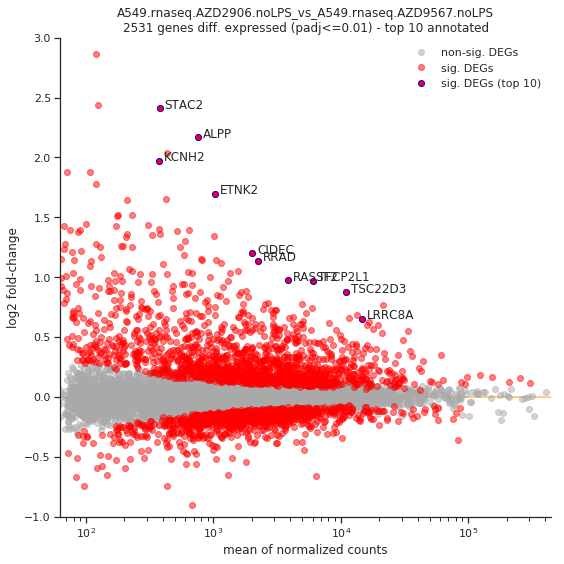

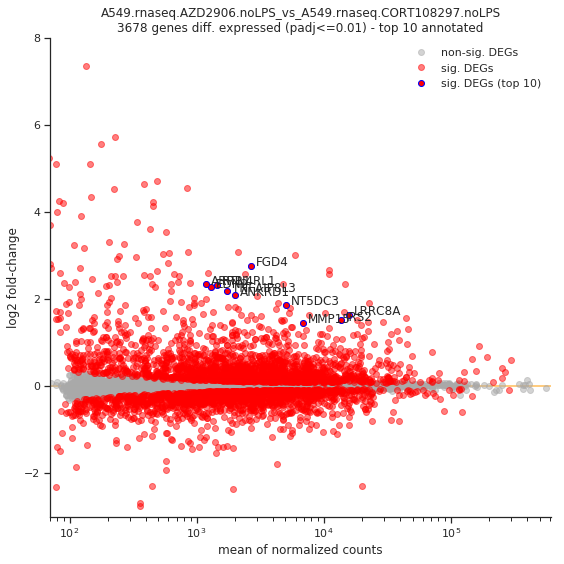

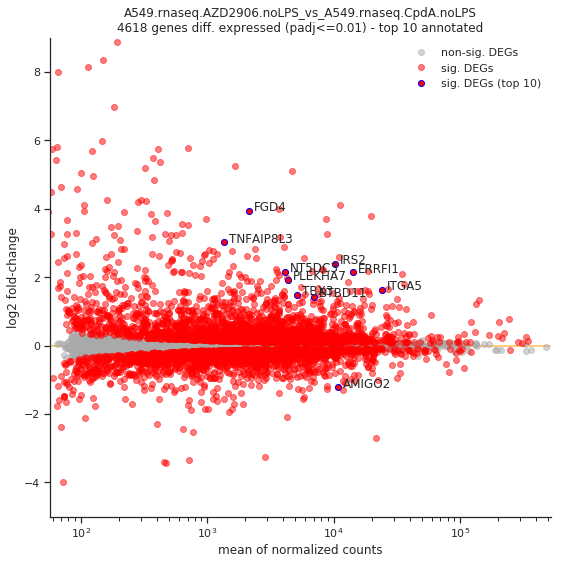

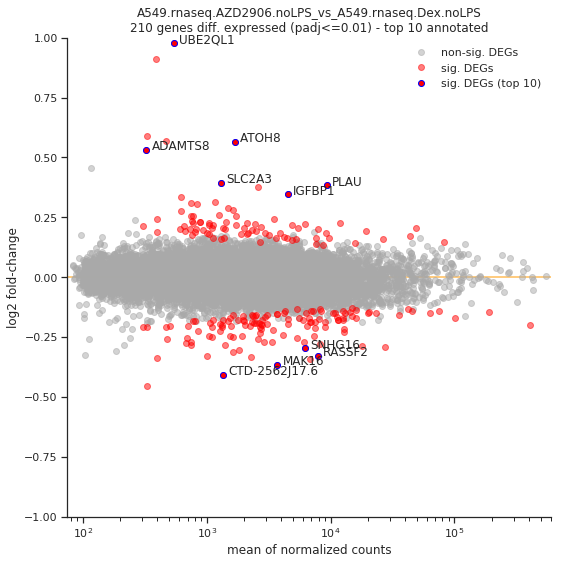

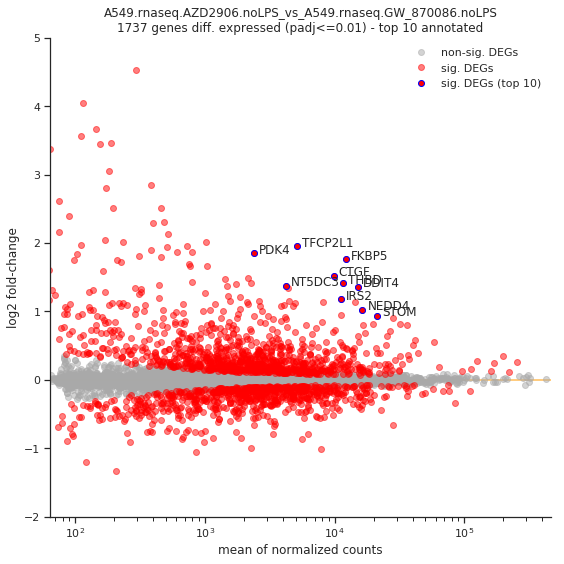

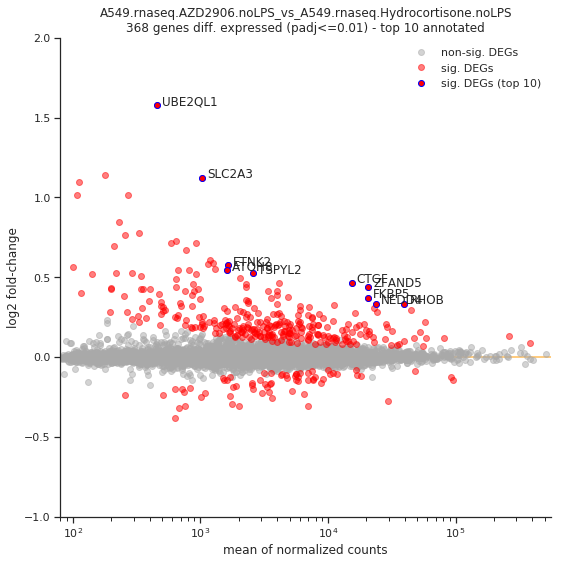

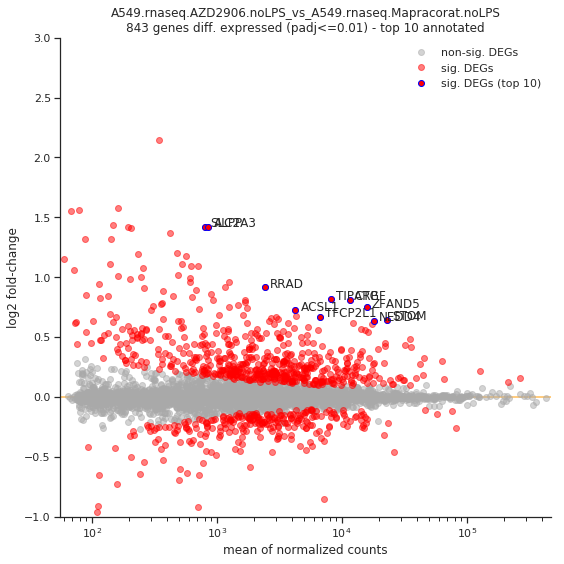

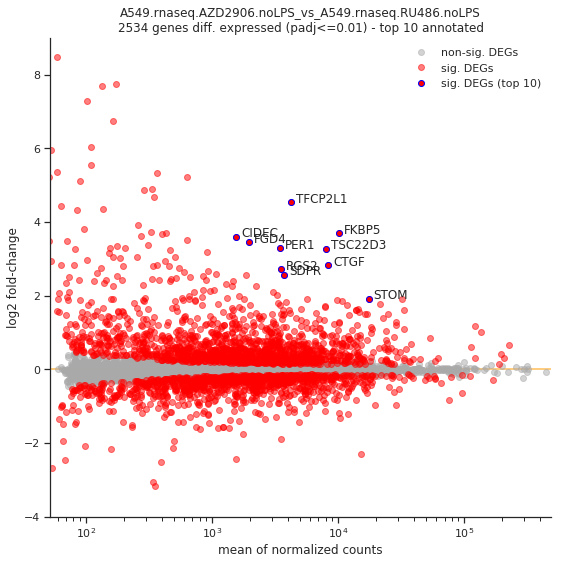

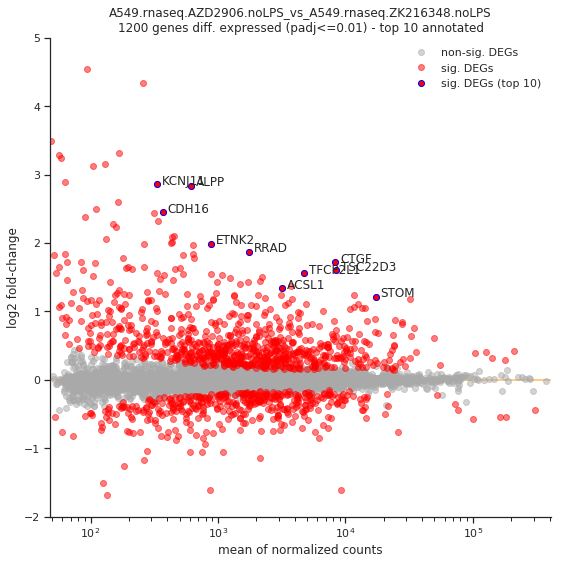

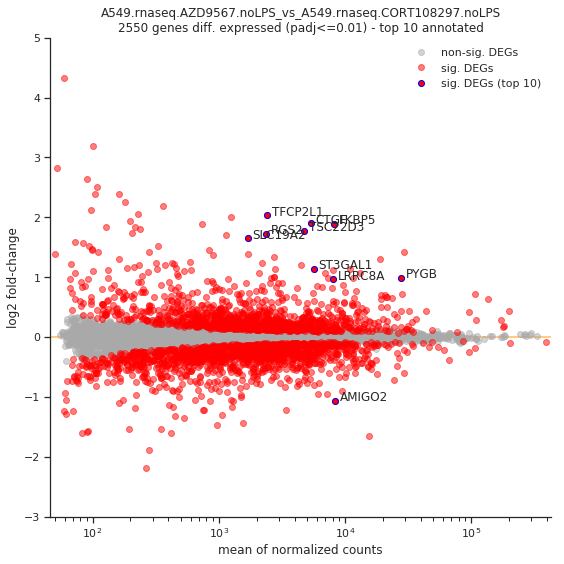

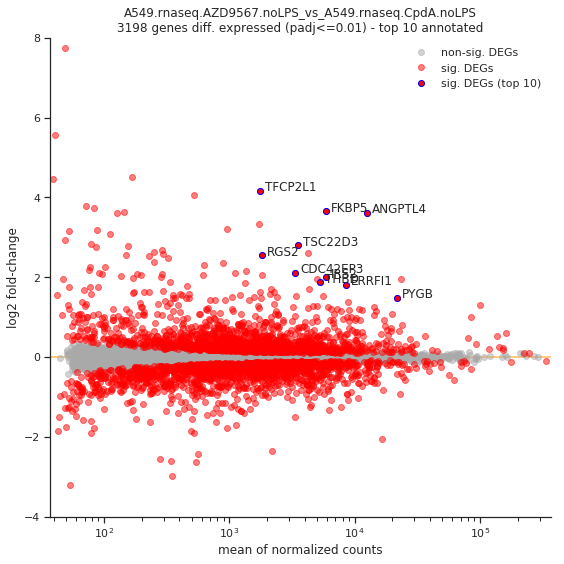

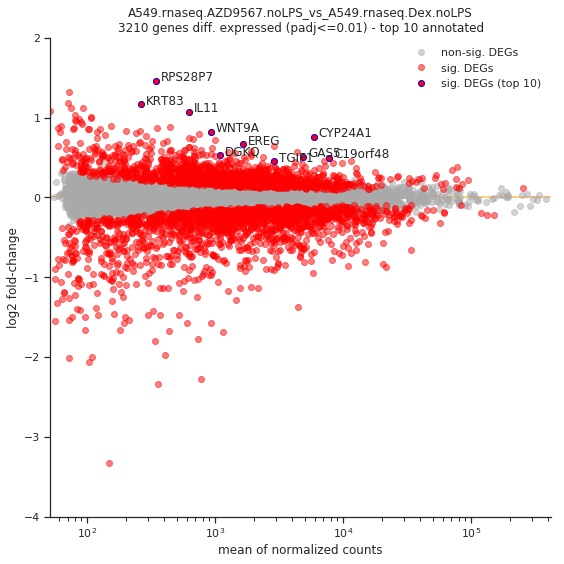

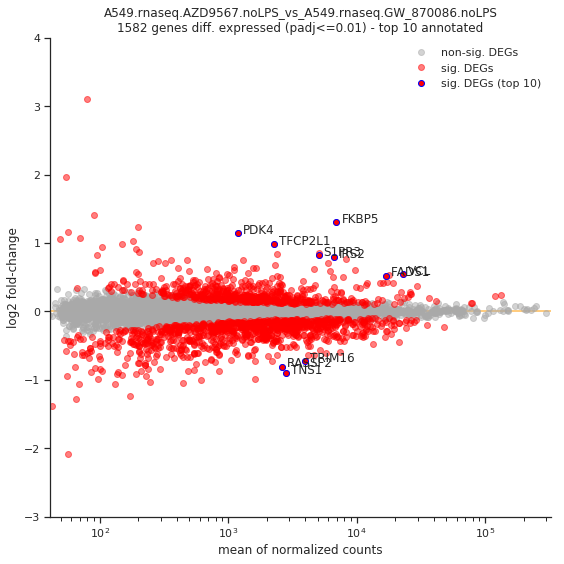

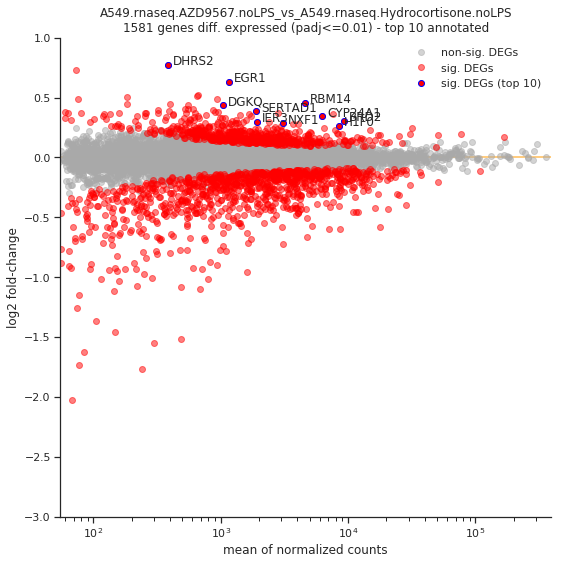

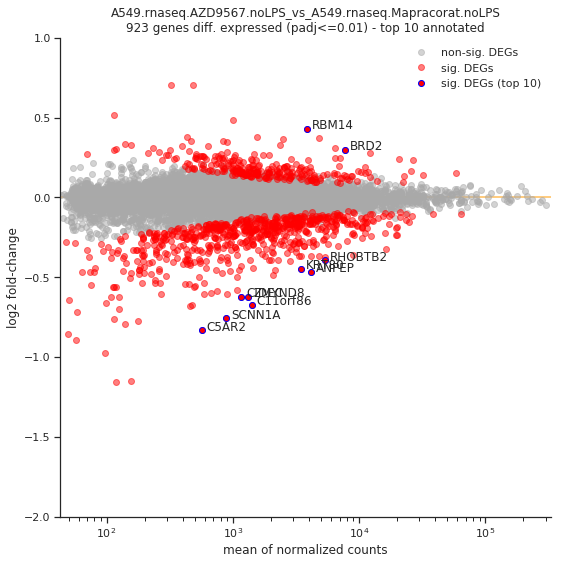

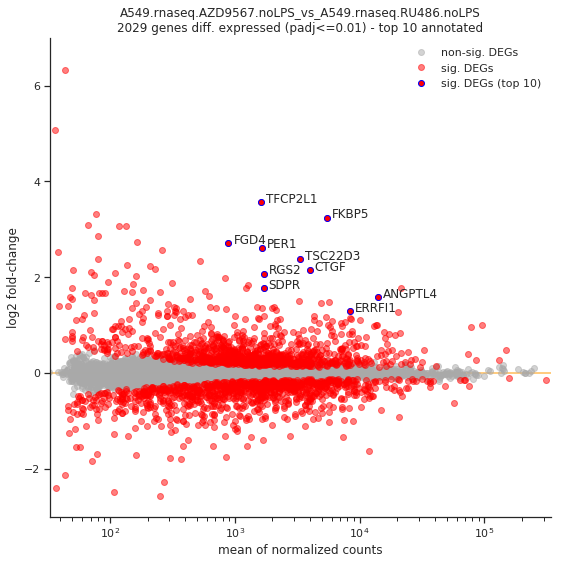

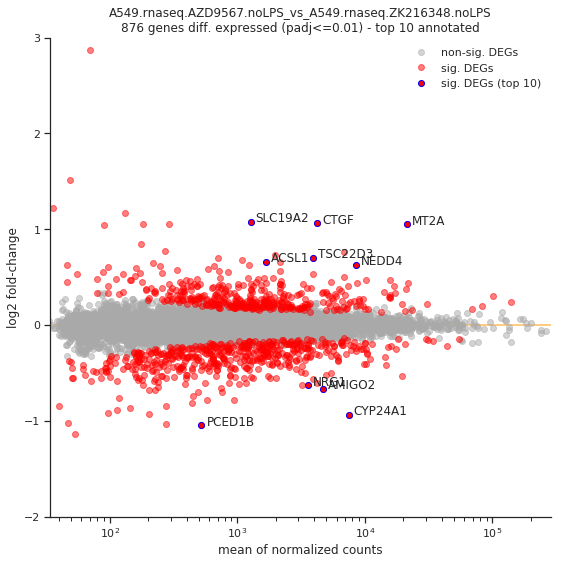

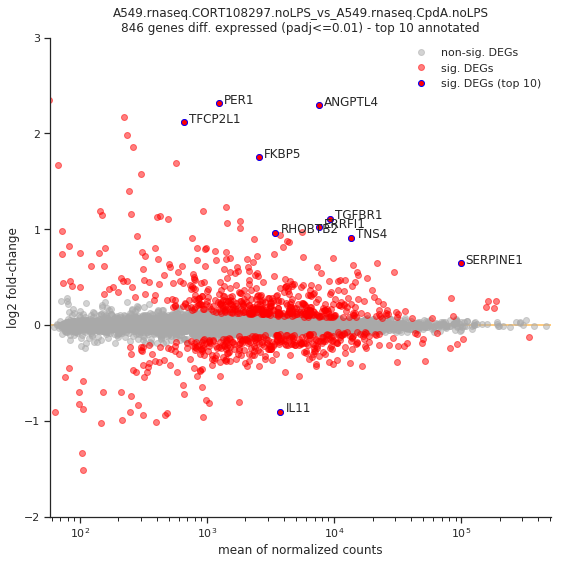

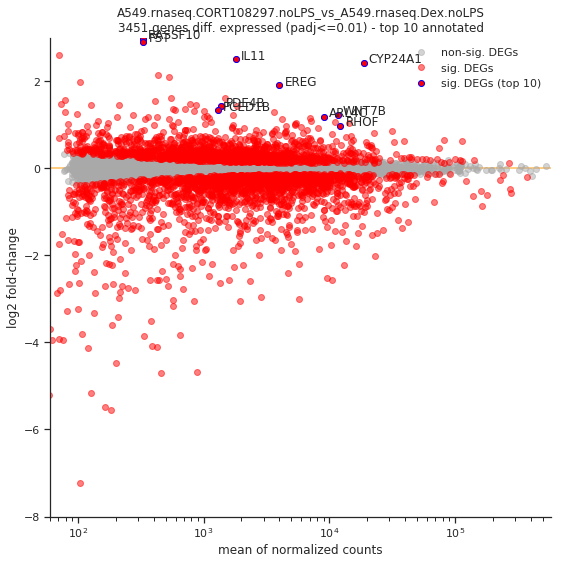

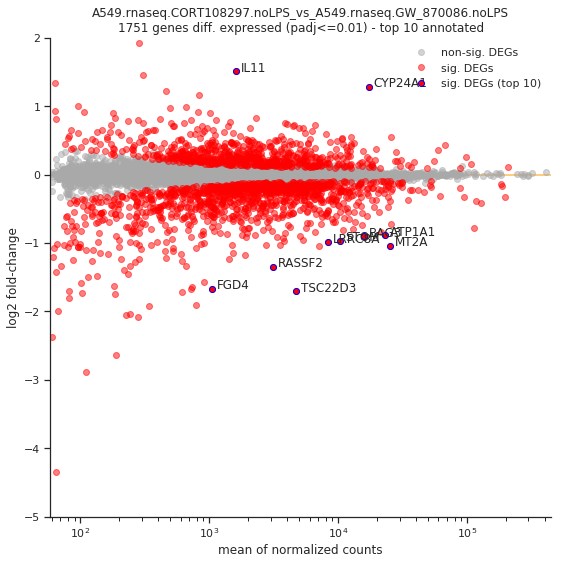

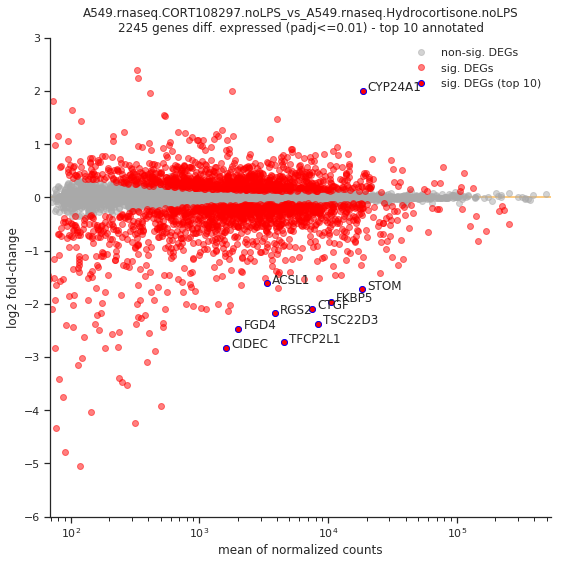

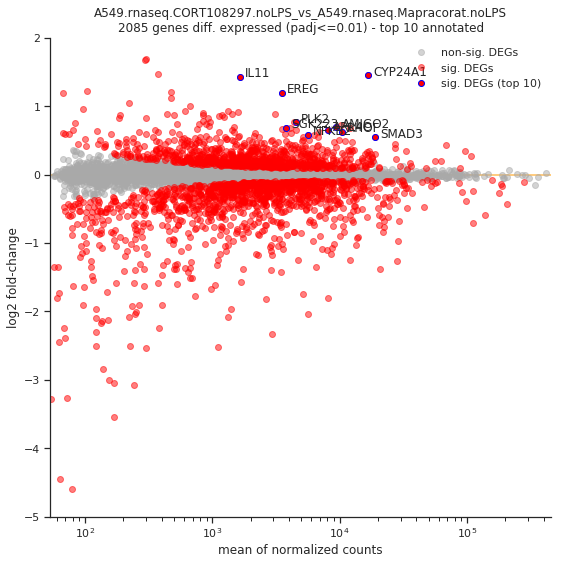

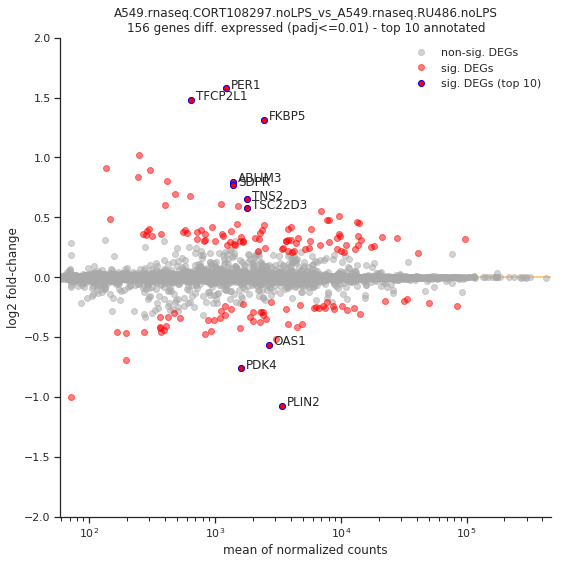

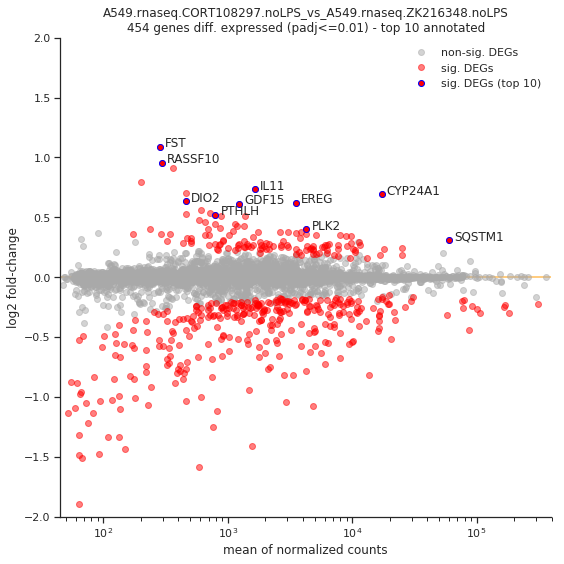

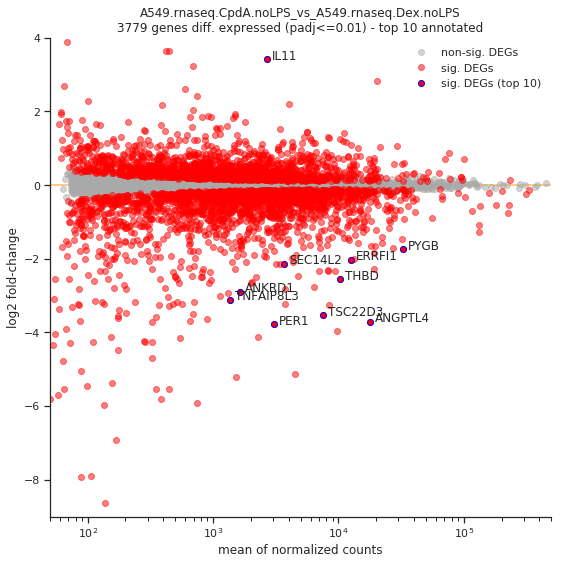

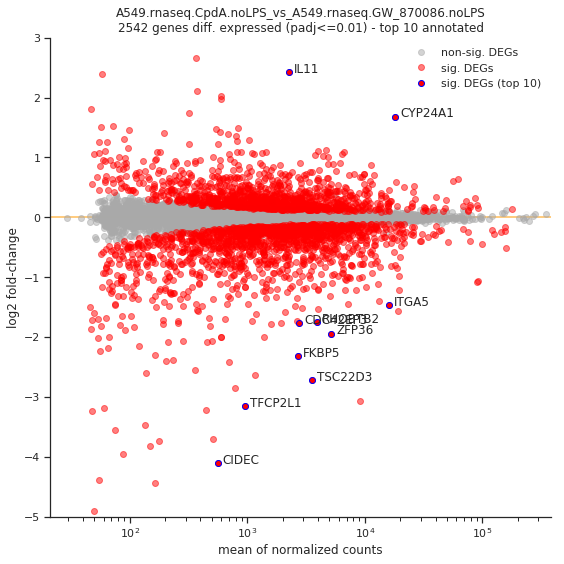

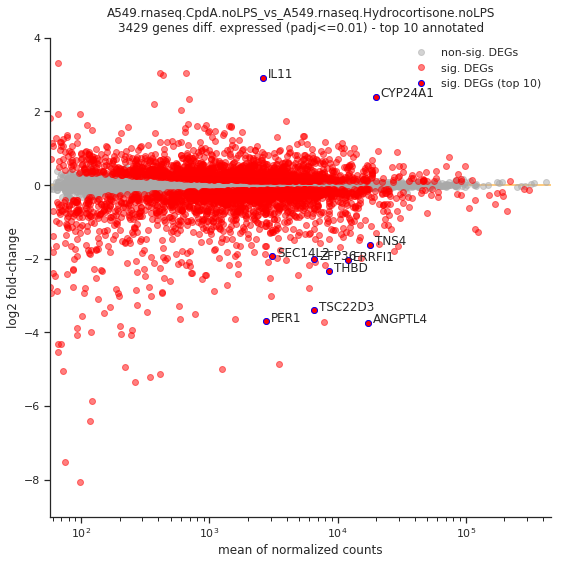

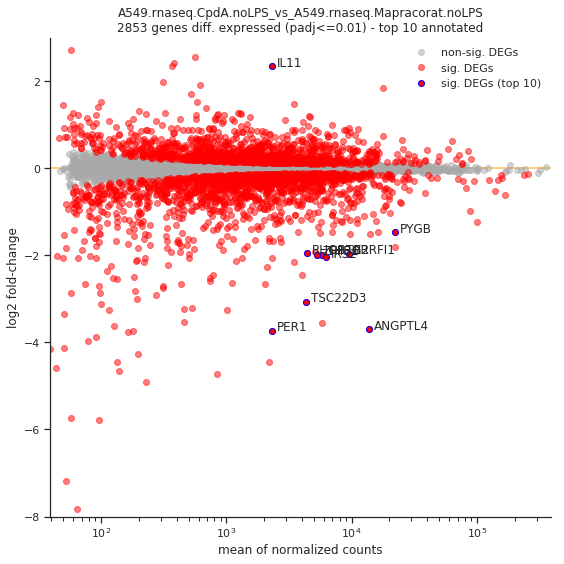

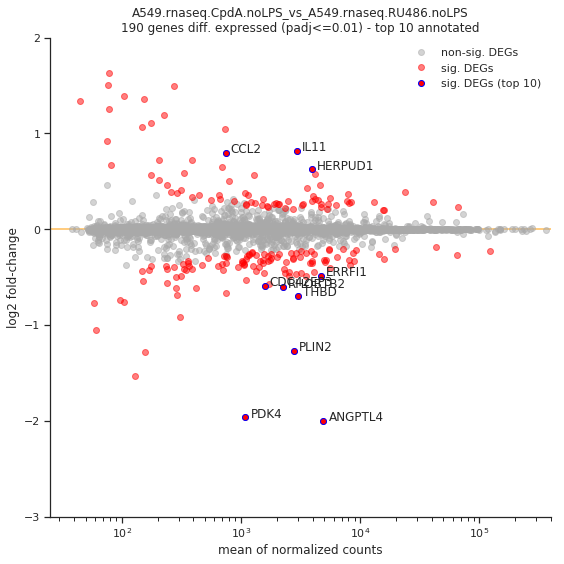

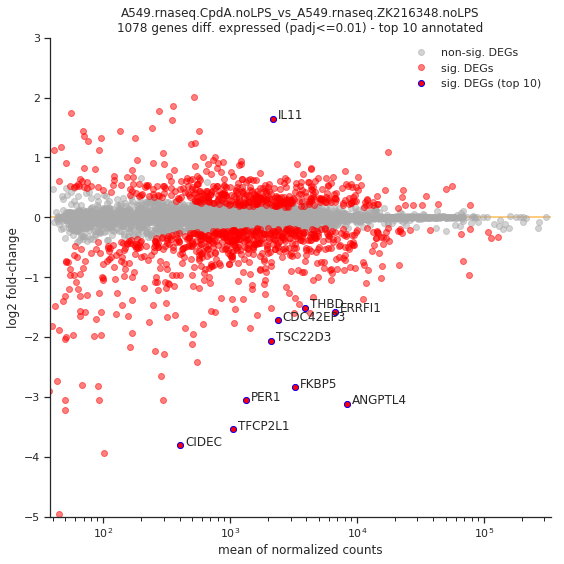

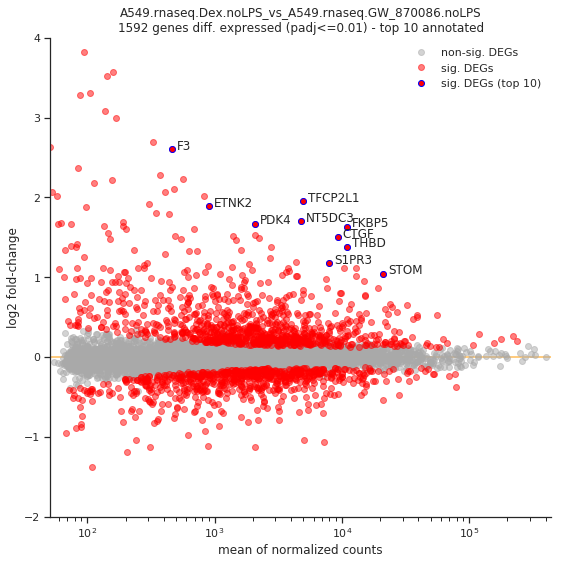

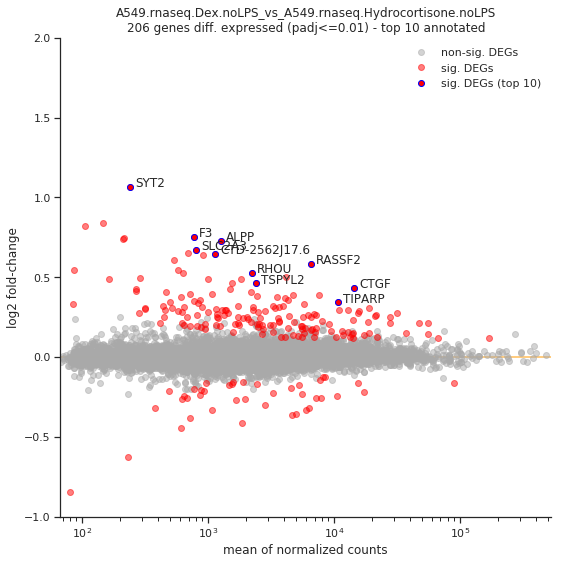

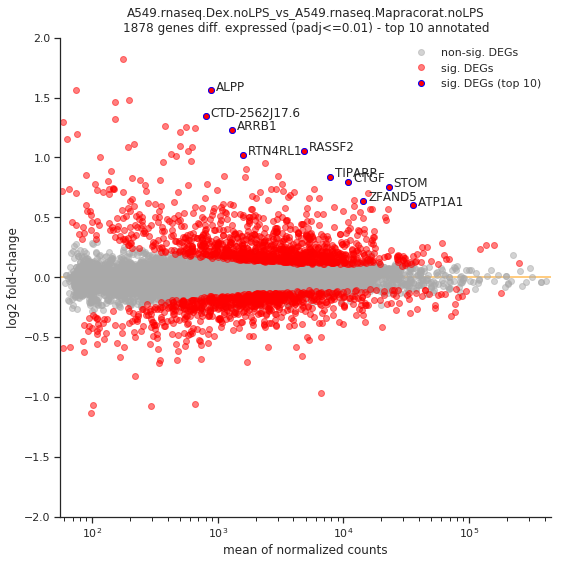

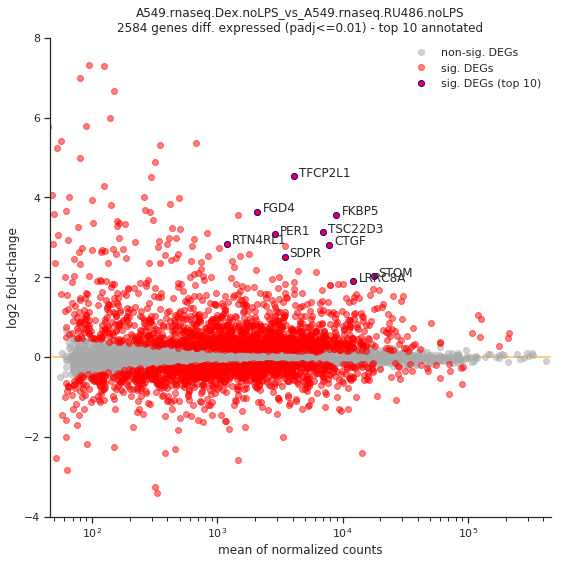

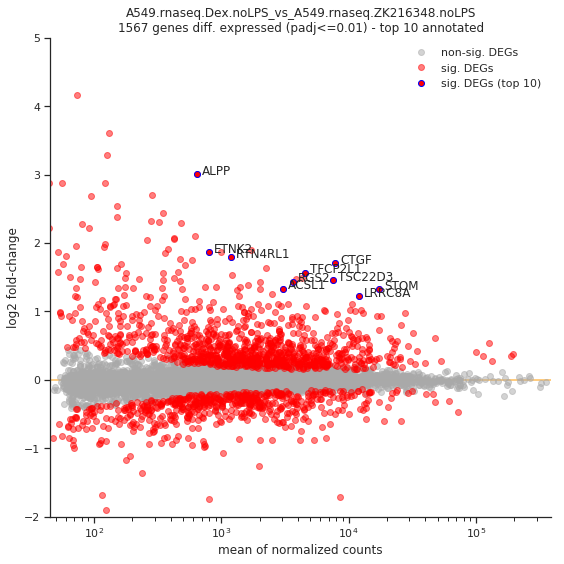

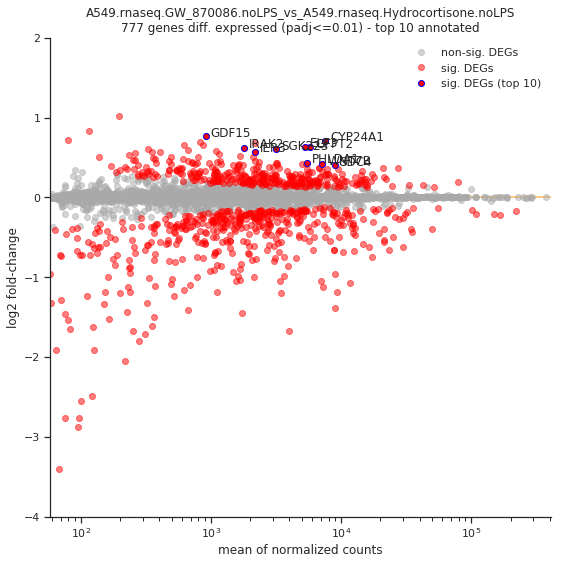

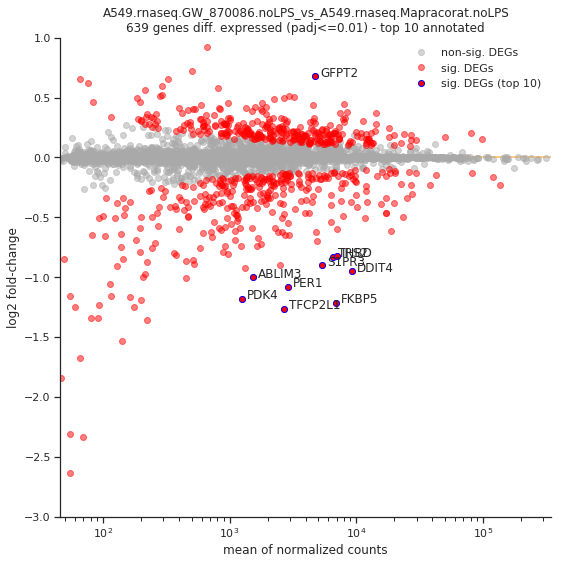

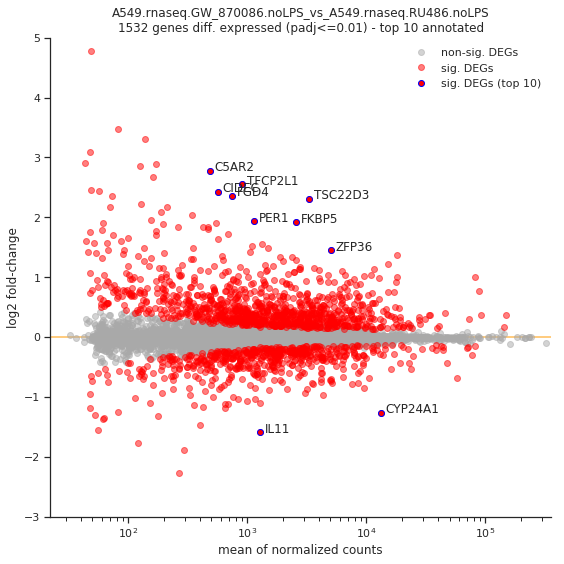

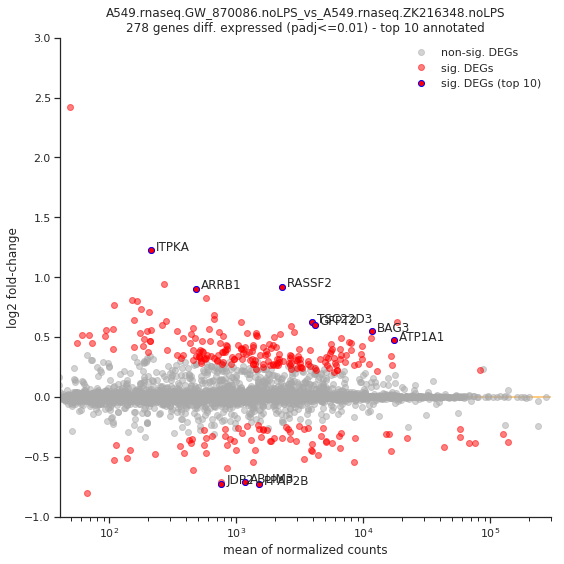

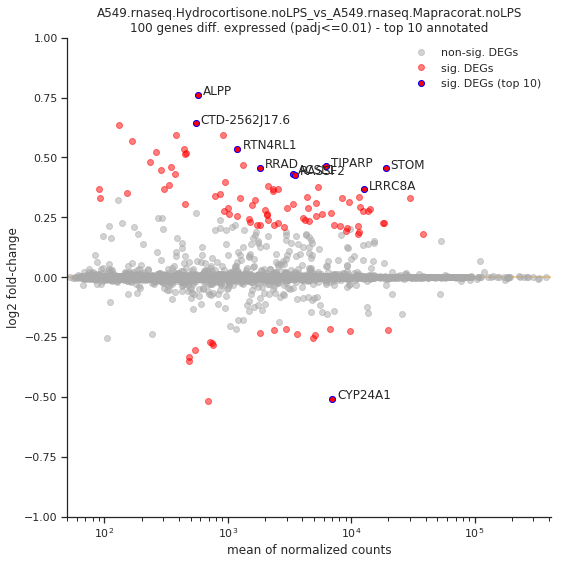

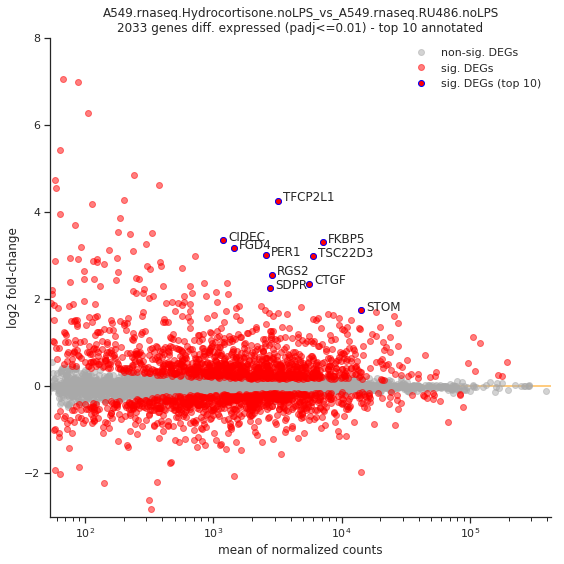

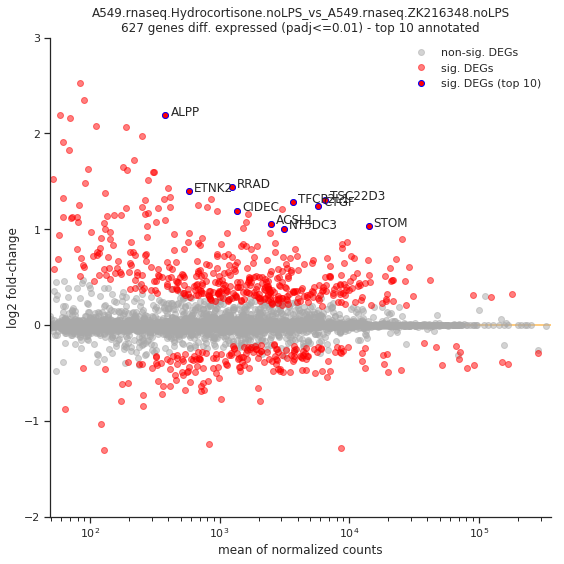

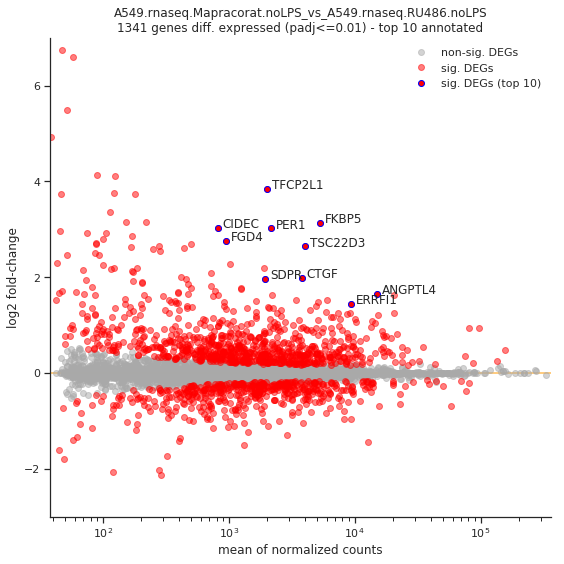

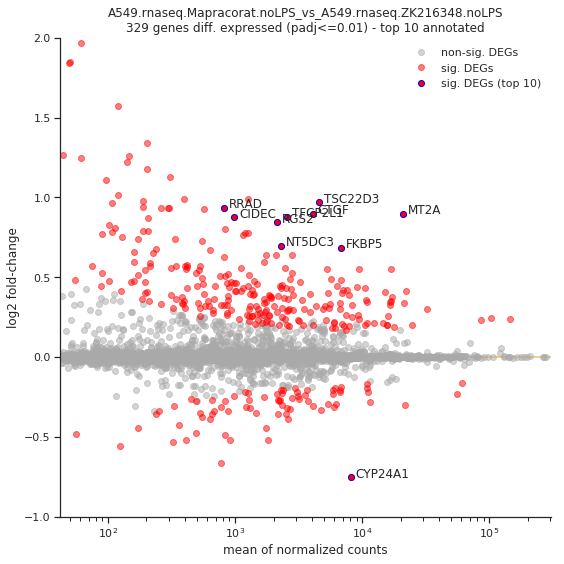

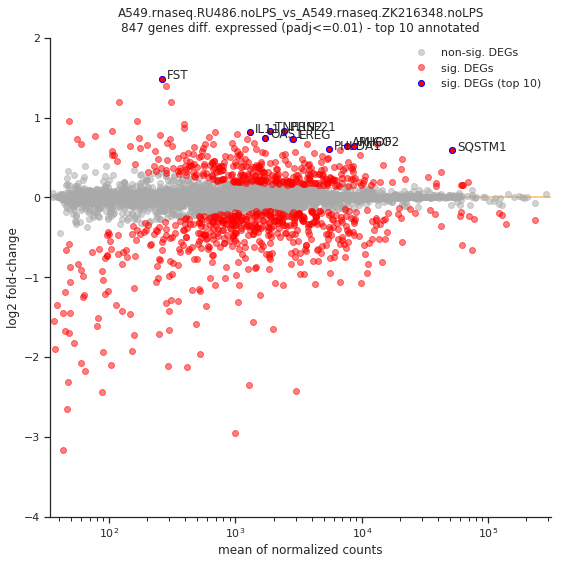

In [4]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 10
log2fc_thres = np.log2(2)
special_genes = []
comparisons = comps

data_dir = '/data/reddylab/Alex/collab/20201029_Graham/results/rna_seq/deseq2/only_treat_ctrls_counts/pairwise/'
for comparison in comparisons:
    for shrinkage in ['']:#, '.unshrunk'
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey',alpha=0.5, label='non-sig. DEGs', rasterized=True)

        ylims = [np.ceil(df['log2FoldChange'].min()-1), np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]

        df_sig = df[(df.padj<=pval_thres)] #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.5, 
                label='sig. DEGs', rasterized=True)

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
        if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
            df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
        ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', 
                label='sig. DEGs (top %d)' % top_to_report, markeredgecolor='blue', rasterized=True)

        for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                        textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
#         df_annotate_selected = df[df.GeneName.isin(special_genes)]
#         ax.plot(df_annotate_selected['baseMean'].values, 
#                 df_annotate_selected['log2FoldChange'].values,color='blue', 
#                 marker='.', linestyle = 'None', alpha=1, label='interest genes')
#         for x, y, t in zip(df_annotate_selected['baseMean'].values,
#                            df_annotate_selected['log2FoldChange'].values, 
#                            df_annotate_selected['GeneName'].values) :
#             ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')
#         df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
#         ax.plot(df_annotate_selected['baseMean'].values, 
#                 df_annotate_selected['log2FoldChange'].values,color='blue', 
#                 marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
#          & (np.abs(df.log2FoldChange)>=log2fc_thres)
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
        plt.savefig("%s/%s%s.with_genes.annotated_plot_MA.pdf" % (data_dir, comparison, shrinkage))
    
        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)

   
